# Network Analysis of Vagrant Developers
<a href="#TODO's">TODO</a><br>
<a href="#Imports">Imports</a><br>
<a href="#Functions">Functions</a><br>
<a href="#Analysis">Analysis</a><br>
<a href="#Graph-Based-Analysis-using-Logistic-Regression,-Random-Forest-Classifer,-and-XGBoost-classifier"><b>Analysis</b> - Graph-Based Analysis using Logistic Regression, Random Forest Classifer, and XGBoost classifier</a><br>
<a href="#Cross-Validation"><b>Analysis</b> - Cross Validation</a><br>
<a href="#Rebalancing-data"><b>Analysis</b> - Data Rebalancing</a>

## TODO's

<ul>
<li>Implement a new dataframe to store the results from each section. (refer to last cell)</li>
</ul>

## Imports

In [1]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import json
import csv
import numpy
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, accuracy_score, precision_recall_curve, plot_precision_recall_curve, auc, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, LeaveOneOut, KFold, StratifiedKFold, RepeatedKFold, TimeSeriesSplit
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
import statsmodels.api as sm
from ast import literal_eval
from statistics import mean
from collections import Counter
import sys
import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
def plot_prediction(model, x, y):
    '''
    Plots the predictions made using a linear regression model 
    given the set of dependent variable(s) and the independent variable
        model: Linear Regression Model
        x: Dependent Variable(s)
        y: Independent Variable
    returns: Independent Variable Predictions
    '''
    y_pred = model.predict(x)
    plt.scatter(x, y)
    plt.plot(x, y_pred, color='red')
    plt.show()
    
    return y_pred

# source: https://stackoverflow.com/questions/26319259/how-to-get-a-regression-summary-in-python-scikit-like-r-does
def regression_results(y_true, y_pred):
    '''
    Analyzes the results from the linear regression model prediction using different metrics, such r^2
    '''
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def Loo(model, x, y):
    '''
    Uses the LeaveOneOut cross-validation method provided by SkLearn
    '''
    loo = LeaveOneOut() 
    highestscore = (0, "")
    y_true, y_pred = list(), list()
    
    # Split the data
    for train_index, test_index in loo.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        predictions = model.predict_proba(x_test)
        yhat = model.predict(x_test) 
        
        # determine PRC_AUC score
        score = model.score(x_test, y_test) # NOTE: Removed the following due to errors: prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if score > highestscore[0]:
            highestscore = (model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}")

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[1])
    print("\nModel Score: {}\n".format(highestscore[0]))
    #acc = accuracy_score(y_true, y_pred)
    #print('Accuracy: %.3f' % acc)
    
    
def Loo_short(model, x, y):
    '''
    Uses the shortened version of the LeaveOneOut cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = LeaveOneOut()
    # to see list of scoring methods, go to: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))
    
def Rkf(model, x, y, threshold=None):
    '''
    Uses the RepeatedKFold cross-validation method provided by SkLearn
    '''
    kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42) 
    #kf.get_n_splits(x)
    #print(kf)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    recall = None
    yhat = None
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
        
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])
        
        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("Average Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)

    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6]
    
def Rkf_short(model, x, y):    
    '''
    Uses the shortened version of the RepeatedKFold cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))
    
def Skf(model, x, y, threshold = None):
    '''
    Uses the StratifiedKFold cross-validation method provided by SkLearn
    '''
    skf = StratifiedKFold(n_splits=10, random_state=None)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    recall = None
    yhat = None
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
            
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])
        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    
    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6]
    
def Skf_short(model, x, y):
    '''
    Uses the shortened version of the StratifiedKFold cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = StratifiedKFold(n_splits=10, random_state=None)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))    

def Tss(model, x, y, threshold=None):
    '''
    Uses the TimeSeriesSplit cross-validation method provided by SkLearn
    '''
    tscv = TimeSeriesSplit(n_splits=5)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    rcall = None
    yhat = None
    
    for train_index, test_index in tscv.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue

        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
        
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])

        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    
    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6]

def Tss_short(model, x, y):
    '''
    Uses the shortened version of the TimeSeriesSplit cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = TimeSeriesSplit(n_splits=10)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores))) 
    
def Compare_Model_Scores(test_x1, test_x2, y_test, predictions1, predictions2, prediction_probs1, prediction_probs2, model1, model2):
    '''
    This method provides different metrics about the predictions associated with an independent test variable.
    These metrics include: PRC-AUC scores, ROC-AUC scores, and the classification report provided by sklearn
    
    print("Predictions for model 1: ")
    print(prediction_probs1)
    print("\nPredictions for model 2: ")
    print(prediction_probs2)
    '''
    
    #recall1, recall2, precision1, precision2, thresholds_list = get_precision_recall(test_x1, test_x2, y_test, model1, model2)
    
    # ovr: One-vs-rest
    # ovo: One-vs-one
    print("\nScores for model 1")
    print("------------------")
    # Temporarily removed to retrieve precision & recall by hand
    
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, prediction_probs1[:, 1]) 
    #retrieve probability of being 1(in second column of probs_y)
    
    pr_auc1 = auc(recall1, precision1)
    roc_val1 = roc_auc_score(y_test, prediction_probs1[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val1))
    prc_val1 = average_precision_score(y_test, prediction_probs1[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val1))
    print(f"PRC-AUC for model 1: {pr_auc1}")
    acc1 = accuracy_score(y_test, predictions1)
    print('Accuracy: %.3f' % acc1)

    '''
    Classification Report breakdown from https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn:
    The recall means "how many of this class you find over the whole number of element of this class"

    The precision will be "how many are correctly classified among that class"

    The f1-score is the harmonic mean between precision & recall

    The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.
    '''

    print("Classification Report:\n")
    print(classification_report(y_test, predictions1))

    print("\nScores for model 2")
    print("------------------")
    
    # Temporarily removed to retrieve precision & recall by hand
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, prediction_probs2[:, 1])
    
    pr_auc2 = auc(recall2, precision2)
    roc_val2 = roc_auc_score(y_test, prediction_probs2[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val2))
    prc_val2 = average_precision_score(y_test, prediction_probs2[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val2))
    print(f"PRC-AUC for model 2: {pr_auc2}")
    print("Classification Report:\n")
    print(classification_report(y_test, predictions2))
    acc2 = accuracy_score(y_test, predictions2)
    print('Accuracy: %.3f' % acc2)
    
    return acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2
    
def Compare_Model_Scores_Best_Threshold(test_x1, test_x2, y_test, predictions1, predictions2, prediction_probs1, prediction_probs2, model1, model2):
    '''
    This method provides different metrics about the predictions associated with an independent test variable.
    These metrics include: PRC-AUC scores, ROC-AUC scores, and the classification report provided by sklearn
    '''


    
    # ovr: One-vs-rest
    # ovo: One-vs-one
    print("\nScores for model 1")
    print("------------------")
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, prediction_probs1[:,1])
    fscore1 = (2 * (np.array(precision1, dtype=float) * np.array(recall1, dtype=float)) / (np.array(precision1, dtype=float) + np.array(recall1, dtype=float)))
    fscore1[np.isnan(fscore1)] = 0 
    # locate the index of the largest f score
    ix1 = np.argmax(fscore1)
    
    pr_auc1 = auc(recall1[ix1:], precision1[ix1:])
    roc_val1 = roc_auc_score(y_test, prediction_probs1[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val1))
    prc_val1 = average_precision_score(y_test, prediction_probs1[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val1))
    print(f"PRC-AUC for model 1: {pr_auc1}")
    
    # Measure the accuracy of the results by comparing the test data with the predictions using the best threshold
    acc1 = accuracy_score(y_test, predictions1)
    print('Accuracy: %.3f' % acc1)

    '''
    Classification Report breakdown from https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn:
    The recall means "how many of this class you find over the whole number of element of this class"

    The precision will be "how many are correctly classified among that class"

    The f1-score is the harmonic mean between precision & recall

    The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.
    '''

    print("Classification Report:\n")
    print(classification_report(y_test, predictions1))

    print("\nScores for model 2")
    print("------------------")
    # Temporarily removed to retrieve precision & recall by hand
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, prediction_probs2[:, 1])
    fscore2 = (2 * (np.array(precision2, dtype=float) * np.array(recall2, dtype=float)) / (np.array(precision2, dtype=float) + np.array(recall2, dtype=float)))
    fscore2[np.isnan(fscore2)] = 0  
    ix2 = np.argmax(fscore2)
    
    pr_auc2 = auc(recall2[ix2:], precision2[ix2:])
    roc_val2 = roc_auc_score(y_test, prediction_probs2[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val2))
    prc_val2 = average_precision_score(y_test, prediction_probs2[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val2))
    print(f"PRC-AUC for model 2: {pr_auc2}")
    print("Classification Report:\n")
    print(classification_report(y_test, predictions2))
    
    # Measure the accuracy of the results by comparing the test data with the predictions using the best threshold
    acc2 = accuracy_score(y_test, predictions2)
    print('Accuracy: %.3f' % acc2)
    
    return acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2

def plot_thresholds(model1, model2, test_x1, test_y1, test_x2, test_y2, prediction_probs1, prediction_probs2, title):
    '''Predict test_y values and probabilities based on fitted logistic for both models''' 

    # recall1, recall2, precision1, precision2, threshold_list = get_precision_recall(test_x1, test_x2, test_y1, model1, model2)
    
    precision1, recall1, thresholds1 = precision_recall_curve(test_y1, prediction_probs1[:, 1]) 
    precision2, recall2, thresholds2 = precision_recall_curve(test_y2, prediction_probs2[:, 1])
    
    # convert to f1 score
    # from: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    fscore1 = (2 * (np.array(precision1, dtype=float) * np.array(recall1, dtype=float)) / (np.array(precision1, dtype=float) + np.array(recall1, dtype=float)))
    fscore2 = (2 * (np.array(precision2, dtype=float) * np.array(recall2, dtype=float)) / (np.array(precision2, dtype=float) + np.array(recall2, dtype=float)))
    fscore1[np.isnan(fscore1)] = 0 
    fscore2[np.isnan(fscore2)] = 0 
    
    # locate the index of the largest f score
    ix1 = np.argmax(fscore1)
    ix2 = np.argmax(fscore2)
    #print(f"F score 1: {fscore1} with ix: {ix1}")
    #print(f"F score 2: {fscore2} with ix: {ix2}")
    print('Best Threshold=%f, F1-Score=%.3f for model 1' % (thresholds1[ix1], fscore1[ix1]))
    print('Best Threshold=%f, F1-Score=%.3f for model 2' % (thresholds2[ix2], fscore2[ix2]))
    
    
    fig = plt.figure()
    
    plt.title(f"PRC for {title}")
    # use marker = "." to see each threshhold value
    plt.plot(recall1[:-1], precision1[:-1], "b", label=f"Model 1\n-----------\n • PRC-AUC score: {auc(recall1[ix1:], precision1[ix1:]):.2f}\n • Best Threshold: {round(thresholds1[ix1], 2):.2f}\n • Best F1-Score: {round(fscore1[ix1], 2):.2f}\n")
    plt.plot(recall2[:-1], precision2[:-1], "r--", label=f"Model 2\n-----------\n • PRC-AUC score: {auc(recall2[ix2:], precision2[ix2:]):.2f}\n • Best Threshold: {round(thresholds2[ix2], 2):.2f}\n • Best F1-Score: {round(fscore2[ix2], 2):.2f}")
    plt.scatter([recall1[ix1], recall2[ix2]], [precision1[ix1], precision2[ix2]], marker='o', color='black', label='Best threshold')
    #plt.annotate('Model 1 Best Threshold=%.2f, Best F1-Score=%.2f' % (thresholds1[ix1], fscore1[ix1]), (0.38, 0.35), fontsize=8)
    #plt.annotate('Model 2 Best Threshold=%.2f, Best F1-Score=%.2f' % (thresholds2[ix2], fscore2[ix2]), (0.38, 0.3), fontsize=8)
    
    x1 = np.array(recall1[ix1:], dtype=float)
    x2 = np.array(recall2[ix2:], dtype=float)
    y1 = np.array(precision1[ix1:], dtype=float)
    y2 = np.array(precision2[ix2:], dtype=float)
    y1_opp = np.array(precision1[ix2:], dtype=float)
    
    #plt.fill_between(x1, y1, color='b', alpha=0.5)
    # where=y1_opp<=y2
    #plt.fill_between(x2, y2, color='r', alpha=0.3)
    
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.ylim([0,1])
    plt.xlim([0,1])
    
    plt.grid()
    plt.show()
    
    return thresholds1[ix1], thresholds2[ix2], fig
    
def simple_threshold_plot(classifier, x_test, y_test):
    predictions = classifier.predict(x_test)
    prc_val = average_precision_score(y_test, predictions)
    disp = plot_precision_recall_curve(classifier, x_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(prc_val))
    
def get_precision_recall(test_x1, test_x2, test_y, model1, model2):
    '''
    Get the the preicison and recall values for every data point with each type of threshold
    '''
    
    recall1, recall2, precision1, precision2 = list(), list(), list(), list()
    
    # Could also create thresholds using: thresholds = arange(0, 1, 0.001)
    # threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    threshold_list = np.arange(0.001, 1, 0.001)
    for threshold in threshold_list:
        #pred_y1=model1.predict(test_x1) 
        probs_y1=(model1.predict_proba(test_x1)[:,1] >= threshold).astype(int)
        #pred_y2=model2.predict(test_x2) 
        probs_y2=(model2.predict_proba(test_x2)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision1.append(precision_score(test_y, probs_y1, average='binary'))
        recall1.append(recall_score(test_y, probs_y1, average='binary'))
        precision2.append(precision_score(test_y, probs_y2, average='binary'))
        recall2.append(recall_score(test_y, probs_y2, average='binary'))
        
    return recall1, recall2, precision1, precision2, threshold_list

def get_precision_recall_best_thresh(test_x1, test_x2, test_y, model1, model2, best_thresh1=None, best_thresh2=None):
    '''
    Get the the preicison and recall values for every data point with the best threshold
    '''
    limit1, limit2 = 1, 1
    if best_thresh1 != None:
        limit1 = best_thresh1
    if best_thresh2 != None:
        limit2 = best_thresh2
    
    recall1, recall2, precision1, precision2 = list(), list(), list(), list()
    
    # Could also create thresholds using: thresholds = arange(0, 1, 0.001)
    # threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    threshold_list = np.arange(0.001, limit1, 0.001)
    for threshold in threshold_list:
        #pred_y1=model1.predict(test_x1) 
        probs_y1=(model1.predict_proba(test_x1)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision1.append(precision_score(test_y, probs_y1, average='binary'))
        recall1.append(recall_score(test_y, probs_y1, average='binary'))
        
    threshold_list = np.arange(0.001, limit2, 0.001)
    for threshold in threshold_list:
        #pred_y2=model2.predict(test_x2) 
        probs_y2=(model2.predict_proba(test_x2)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision2.append(precision_score(test_y, probs_y2, average='binary'))
        recall2.append(recall_score(test_y, probs_y2, average='binary'))
    return recall1, recall2, precision1, precision2, threshold_list

## Analysis

### Graph-Based Analysis using Logistic Regression, Random Forest Classifer, and XGBoost classifier

In [3]:
# Create a dataframe of all of the unique commits (i.e. links) between developers and the corresponding folders
graph_df = pd.read_csv("../../Neo4j_output/JiT_Reliability_Output/Geronimo.csv")

new_columns = {}

# Generate binary classification for our dataframe based on if a developer 
# introduced a bug or not with the corresponding commit
for index in graph_df.index:
    if graph_df.loc[index, "Bug"] != "INTRODUCED_NEW_BUG":
        graph_df.loc[index, "Bug"] = 0
    else:
        graph_df.loc[index, "Bug"] = 1
        
    # separate each node2vec embedding into it's own unique label
    embeddings = literal_eval(graph_df.loc[index, 'n2vEmbedding'])
    for i, embedding in enumerate(embeddings):
        if f"emb_{i}" not in new_columns:
            new_columns[f"emb_{i}"] = []
            new_columns[f"emb_{i}"].append(embedding)
        else:
            new_columns[f"emb_{i}"].append(embedding)

# delete the n2vEmbedding label, as the list has now been separated into their own unique labels 
del graph_df['n2vEmbedding']
temp_df = pd.DataFrame.from_dict(new_columns)
graph_df = graph_df.join(temp_df)
            
graph_df['Bug'] = graph_df.Bug.astype('int')    

x = graph_df["Name"]
y = graph_df["Bug"]

In [4]:
graph_df

,Name,File,Bug,PageRank,Betweenness,Closeness,Harmonic,Degree,communityId,emb_0,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,Haihong Xu,testsuite/console-testsuite/advanced/src/test/...,0,1.390091,36.672537,0.797297,0.858333,11134.0,54,0.621351,...,-0.541832,0.403564,0.543604,0.353052,0.613884,0.136119,-0.160030,-0.142865,-0.180027,-0.251918
1,Haihong Xu,testsuite/console-testsuite/advanced/src/test/...,0,1.390091,36.672537,0.797297,0.858333,11134.0,54,0.621351,...,-0.541832,0.403564,0.543604,0.353052,0.613884,0.136119,-0.160030,-0.142865,-0.180027,-0.251918
2,Haihong Xu,plugins/activemq/activemq-broker/src/main/reso...,0,1.390091,36.672537,0.797297,0.858333,11134.0,54,0.621351,...,-0.541832,0.403564,0.543604,0.353052,0.613884,0.136119,-0.160030,-0.142865,-0.180027,-0.251918
3,Haihong Xu,plugins/activemq/activemq-broker/src/main/reso...,0,1.390091,36.672537,0.797297,0.858333,11134.0,54,0.621351,...,-0.541832,0.403564,0.543604,0.353052,0.613884,0.136119,-0.160030,-0.142865,-0.180027,-0.251918
4,Haihong Xu,testsuite/console-testsuite/advanced/src/test/...,0,1.390091,36.672537,0.797297,0.858333,11134.0,54,0.621351,...,-0.541832,0.403564,0.543604,0.353052,0.613884,0.136119,-0.160030,-0.142865,-0.180027,-0.251918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120725,Hemapani Srinath Perera,modules/axis/src/{samples/echo-pojo/org/apache...,1,0.186570,0.000000,0.584158,0.633333,317.0,53,-0.718470,...,0.358514,-0.520828,-0.565760,0.376422,0.642261,-0.336770,0.315851,0.204363,0.768310,-0.403464
120726,Hemapani Srinath Perera,modules/axis/src/java/org/apache/geronimo/axis...,1,0.186570,0.000000,0.584158,0.633333,317.0,53,-0.718470,...,0.358514,-0.520828,-0.565760,0.376422,0.642261,-0.336770,0.315851,0.204363,0.768310,-0.403464
120727,Hemapani Srinath Perera,modules/axis/src/test-resources/echo-deploy.wsdd,1,0.186570,0.000000,0.584158,0.633333,317.0,53,-0.718470,...,0.358514,-0.520828,-0.565760,0.376422,0.642261,-0.336770,0.315851,0.204363,0.768310,-0.403464
120728,Greg Stein,STATUS,0,0.164535,0.000000,0.584158,0.633333,34.0,53,-0.676242,...,0.726650,-0.269360,0.555594,-0.085883,0.303617,-0.033462,-0.702515,0.784782,0.659049,0.360739


Print out the class counts for our binary classification. In this case, our results are 40,143 <b>False (0)</b> counts, and 1,947 <b>True (1)</b> counts.

In [5]:
print(graph_df['Bug'].value_counts())
# 2D Array containing all results
results_data = [[None for j in range(9)] for i in range(72)]

0    69051
1    51679
Name: Bug, dtype: int64


Creating models...

In [6]:
lr_model1 = LogisticRegression(solver='liblinear', random_state=0)
lr_model2 = LogisticRegression(solver='liblinear', random_state=0)
rf_model1 = RandomForestClassifier(n_estimators=120)
rf_model2 = RandomForestClassifier(n_estimators=120)
xgb_model1 = XGBClassifier(verbosity = 0)
xgb_model2 = XGBClassifier(verbosity = 0)

In [7]:
'''
train_test_split params
-----------------------
graph_df: Graph dataset
test_size: float value between 0.0 and 1.0 representing the precentage of data to be put into the test dataset
random_state = used to create reproducible, or deterministic results.
'''
train, test = train_test_split(graph_df, test_size=0.3, random_state = 5)
train = train.reset_index()
test = test.reset_index()

# Labels used for model 1
labels1 = ['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']

# Labels used for model 2
labels2 = set(list(graph_df.columns))
labels2.difference_update(['index', 'Bug', 'Name', 'File', 'PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree'])

x1_train = train[labels1]
x2_train = train[labels2]
y_train = train["Bug"]
x1_test = test[labels1]
x2_test = test[labels2]
y_test = test["Bug"]

In [8]:
print(train['Bug'].value_counts())
train

0    48459
1    36052
Name: Bug, dtype: int64


,index,Name,File,Bug,PageRank,Betweenness,Closeness,Harmonic,Degree,communityId,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,27438,David Jencks,applications/daytrader/{modules => }/ejb/src/j...,1,5.714591,312.183426,1.000000,0.983333,93714.0,54,...,0.142667,-0.587126,-0.043076,0.770264,-0.563122,0.366593,-0.225179,-0.125074,-0.030246,-0.251655
1,48499,Richard McGuire,plugins/wab/web-extender/src/main/history/depe...,1,1.848536,74.487937,0.893939,0.925000,16594.0,54,...,-0.137477,0.665398,-0.114869,0.411506,-0.222960,-0.238982,0.653966,0.096164,0.787751,0.552772
2,61727,Jason Dillon,modules/{management => geronimo-management}/sr...,0,3.540649,146.110288,0.983333,0.975000,35101.0,53,...,0.472873,0.388830,0.569218,0.002084,-0.234434,-0.212352,-0.478211,0.124225,0.507888,0.020878
3,65394,Jason Dillon,testsuite/enterprise-testsuite/jms-tests/jms-e...,0,3.540649,146.110288,0.983333,0.975000,35101.0,53,...,0.472873,0.388830,0.569218,0.002084,-0.234434,-0.212352,-0.478211,0.124225,0.507888,0.020878
4,1742,Haihong Xu,plugins/activemq/activemq-portlets/src/main/ja...,0,1.390091,36.672537,0.797297,0.858333,11134.0,54,...,-0.541832,0.403564,0.543604,0.353052,0.613884,0.136119,-0.160030,-0.142865,-0.180027,-0.251918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84506,5520,Jarek Gawor,testsuite/web-testsuite/test-web-forward/web-f...,0,2.313021,85.455631,0.880597,0.916667,23821.0,54,...,0.819028,-0.611931,0.031355,0.011010,0.436898,-0.183769,-0.368580,-0.171950,-0.268999,-0.542053
84507,101350,Paul Franklin McMahan,plugins/console/console-base-portlets/src/main...,1,0.958591,9.407027,0.786667,0.850000,3979.0,54,...,-0.153682,-0.458545,-0.208857,-0.299087,0.223778,0.237841,0.437868,0.079608,0.297211,0.610609
84508,20463,David Jencks,plugins/openejb/geronimo-openejb-builder/src/m...,0,5.714591,312.183426,1.000000,0.983333,93714.0,54,...,0.142667,-0.587126,-0.043076,0.770264,-0.563122,0.366593,-0.225179,-0.125074,-0.030246,-0.251655
84509,18638,David Jencks,framework/modules/geronimo-management/src/main...,0,5.714591,312.183426,1.000000,0.983333,93714.0,54,...,0.142667,-0.587126,-0.043076,0.770264,-0.563122,0.366593,-0.225179,-0.125074,-0.030246,-0.251655


Print out the class counts for our binary classification in the training dataset. In this case, our results are 12,060 <b>False (0)</b> counts, and 567 <b>True (1)</b> counts.

In [9]:
print(test['Bug'].value_counts())
test

0    20592
1    15627
Name: Bug, dtype: int64


,index,Name,File,Bug,PageRank,Betweenness,Closeness,Harmonic,Degree,communityId,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,42549,Kevan Lee Miller,plugins/monitoring/mconsole-war/src/main/webap...,1,2.528956,68.531139,0.907692,0.933333,12218.0,54,...,-0.097903,-0.166725,0.314924,0.734786,-0.514497,0.512340,-0.502456,-0.399853,-0.343017,0.323838
1,15315,David Jencks,configs/jetty6/pom.xml,0,5.714591,312.183426,1.000000,0.983333,93714.0,54,...,0.142667,-0.587126,-0.043076,0.770264,-0.563122,0.366593,-0.225179,-0.125074,-0.030246,-0.251655
2,30161,David Jencks,plugins/connector-1_6/geronimo-connector-build...,1,5.714591,312.183426,1.000000,0.983333,93714.0,54,...,0.142667,-0.587126,-0.043076,0.770264,-0.563122,0.366593,-0.225179,-0.125074,-0.030246,-0.251655
3,43182,Kevan Lee Miller,modules/geronimo-connector/src/main/java/org/a...,1,2.528956,68.531139,0.907692,0.933333,12218.0,54,...,-0.097903,-0.166725,0.314924,0.734786,-0.514497,0.512340,-0.502456,-0.399853,-0.343017,0.323838
4,116734,Geir Magnusson Jr,modules/core/src/java/javax/transaction/xa/XAR...,1,0.641782,4.843671,0.678161,0.750000,1820.0,53,...,-0.451846,0.412149,-0.109159,0.419089,0.285466,-0.350473,-0.664052,-0.825821,-0.001994,-0.370275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36214,97491,Prasad Kashyap,framework/modules/geronimo-deploy-jsr88/LICENS...,1,2.729456,26.795347,0.842857,0.891667,14327.0,54,...,0.086107,-0.211931,-0.233705,0.269187,0.297207,-0.198192,-0.347532,-0.710428,-0.623385,-0.501690
36215,39163,Lei Wang,plugins/console/console-base-portlets/src/main...,0,0.934345,19.013850,0.776316,0.841667,3532.0,54,...,0.316936,-0.326174,-0.300130,-0.357741,-0.081015,-0.365125,-0.375508,0.571179,0.308807,0.757903
36216,119205,Jeremy Boynes,modules/core/src/java/org/apache/geronimo/cons...,0,1.515164,13.228206,0.719512,0.791667,10471.0,53,...,-0.343448,0.420690,0.218483,0.446096,-0.198126,-0.313045,-0.479538,-0.191130,-0.391314,0.403235
36217,3066,Ming Xia,testsuite/security-testsuite/test-security-ann...,0,1.331530,19.172612,0.786667,0.850000,5457.0,54,...,-0.277151,-0.009844,0.344377,-0.146634,-0.209375,-0.438678,0.118462,0.282051,0.325326,-0.391726


In [10]:
lr_model1.fit(x1_train, y_train)
lr_model2.fit(x2_train, y_train)
rf_model1.fit(x1_train, y_train)
rf_model2.fit(x2_train, y_train)
xgb_model1.fit(x1_train, y_train)
xgb_model2.fit(x2_train, y_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y_test)}")
results_data[0][0] = "Original_Logistic_Regression"
results_data[0][1] = lr_model1.score(x1_test, y_test)
results_data[0][2] = lr_model2.score(x2_test, y_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y_test)}")
results_data[1][0] = "Original_Random_Forrest"
results_data[1][1] = rf_model1.score(x1_test, y_test)
results_data[1][2] = rf_model2.score(x2_test, y_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y_test)}")
results_data[2][0] = "Original_XGB_Classifier"
results_data[2][1] = xgb_model1.score(x1_test, y_test)
results_data[2][2] = xgb_model2.score(x2_test, y_test)

Logistic regression training score for model 1: 0.5685413733123499
Logistic regression training score for model 2: 0.6491068223860404
Random Forrest Classification training score for model 1: 0.6491344322040917
Random Forrest Classification training score for model 2: 0.6491344322040917
XGB Classifier training score for model 1: 0.6491344322040917
XGB Classifier training score for model 2: 0.6491344322040917


Compare model scores for Logistic Regression

In [11]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[0][3] = acc1
results_data[0][4] = acc2
results_data[0][5] = prc_val1
results_data[0][6] = prc_val2
results_data[0][7] = pr_auc1
results_data[0][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[1][3] = acc1
results_data[1][4] = acc2
results_data[1][5] = prc_val1
results_data[1][6] = prc_val2
results_data[1][7] = pr_auc1
results_data[1][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[2][3] = acc1
results_data[2][4] = acc2
results_data[2][5] = prc_val1
results_data[2][6] = prc_val2
results_data[2][7] = pr_auc1
results_data[2][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.49908362156994324
Average Precision-Recall Score: 0.4487536697725878
PRC-AUC for model 1: 0.513489596588879
Accuracy: 0.569
Classification Report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.72     20592
           1       0.00      0.00      0.00     15627

    accuracy                           0.57     36219
   macro avg       0.28      0.50      0.36     36219
weighted avg       0.32      0.57      0.41     36219


Scores for model 2
------------------
Roc_Auc Score: 0.7002561434374163
Average Precision-Recall Score: 0.6151955269773276
PRC-AUC for model 2: 0.6293077449474278
Classification Report:

              precision    recall  f1-score   support

           0       0.63      0.90      0.74     20592
           1       0.71      0.32      0.44     15627

    accuracy      

###### Compare Precision-Recall thresholds between models

TODO: Get it to work with randomforrest and XGBoost

Best Threshold=0.395516, F1-Score=0.603 for model 1
Best Threshold=0.312876, F1-Score=0.643 for model 2


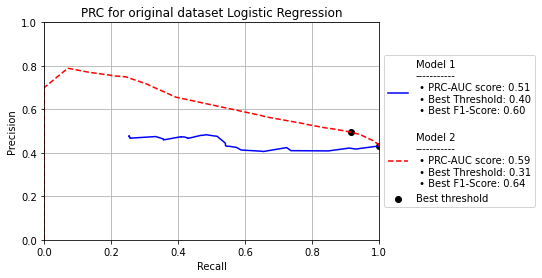

In [12]:
lr_best_threshold1, lr_best_threshold2, lr_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y_test, x2_test, y_test, lr_prediction_probs1, lr_prediction_probs2, "original dataset Logistic Regression")

Best Threshold=0.311300, F1-Score=0.643 for model 1
Best Threshold=0.310793, F1-Score=0.643 for model 2


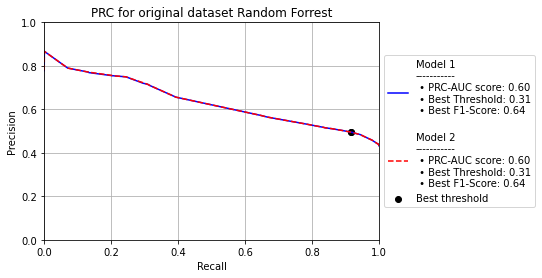

In [13]:
rf_best_threshold1, rf_best_threshold2, rf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y_test, x2_test, y_test, rf_prediction_probs1, rf_prediction_probs2, "original dataset Random Forrest")

Best Threshold=0.313805, F1-Score=0.643 for model 1
Best Threshold=0.312933, F1-Score=0.643 for model 2


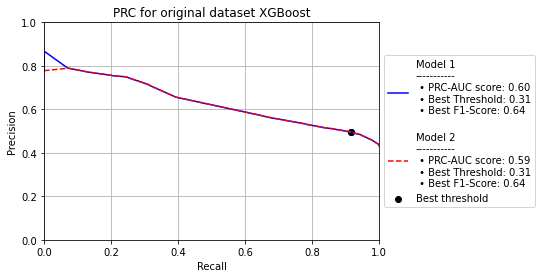

In [14]:
xgb_best_threshold1, xgb_best_threshold2, xgb_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y_test, x2_test, y_test, xgb_prediction_probs1, xgb_prediction_probs2, "original dataset XGBoost")

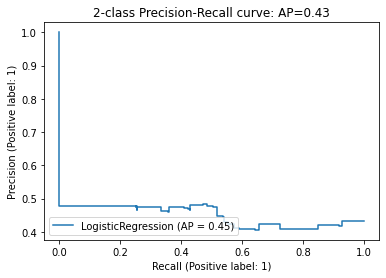

In [15]:
simple_threshold_plot(lr_model1, x1_test, y_test)

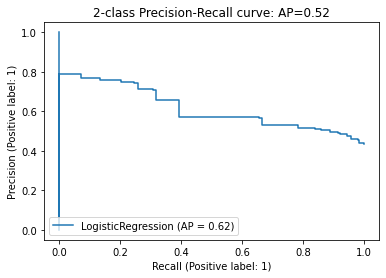

In [16]:
simple_threshold_plot(lr_model2, x2_test, y_test)

Using the best thresholds...

In [17]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)

results_data[3][0] = "Original_Logistic_Regression_Best_Threshold"
results_data[3][1] = lr_model1.score(x1_test, y_test)
results_data[3][2] = lr_model2.score(x2_test, y_test)
results_data[3][3] = acc1
results_data[3][4] = acc2
results_data[3][5] = prc_val1
results_data[3][6] = prc_val2
results_data[3][7] = pr_auc1
results_data[3][8] = pr_auc2

rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[4][0] = "Original_Random_Forrest_Best_Threshold"
results_data[4][1] = rf_model1.score(x1_test, y_test)
results_data[4][2] = rf_model2.score(x2_test, y_test)
results_data[4][3] = acc1
results_data[4][4] = acc2
results_data[4][5] = prc_val1
results_data[4][6] = prc_val2
results_data[4][7] = pr_auc1
results_data[4][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[5][0] = "Original_XGBoost_Classifier_Best_Threshold"
results_data[5][1] = xgb_model1.score(x1_test, y_test)
results_data[5][2] = xgb_model2.score(x2_test, y_test)
results_data[5][3] = acc1
results_data[5][4] = acc2
results_data[5][5] = prc_val1
results_data[5][6] = prc_val2
results_data[5][7] = pr_auc1
results_data[5][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.49908362156994324
Average Precision-Recall Score: 0.4487536697725878
PRC-AUC for model 1: 0.513489596588879
Accuracy: 0.431
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     20592
           1       0.43      1.00      0.60     15627

    accuracy                           0.43     36219
   macro avg       0.22      0.50      0.30     36219
weighted avg       0.19      0.43      0.26     36219


Scores for model 2
------------------
Roc_Auc Score: 0.7002561434374163
Average Precision-Recall Score: 0.6151955269773276
PRC-AUC for model 2: 0.5898948154691017
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.29      0.43     20592
           1       0.50      0.92      0.64     15627

    accuracy                           0.56     36219
   macro avg       0.66      0.60      0.54     36219
weighted 

### Cross Validation

In [18]:
x1 = graph_df[labels1]
x2 = graph_df[labels2]
y = graph_df['Bug']

In [19]:
print("Cross validation results for model 1")
print("------------------------------------")

cv_results = cross_validate(lr_model1, x1, y, cv=3)
sorted(cv_results.keys())
print(cv_results['test_score'])

print("\nCross validation results for model 2")
print("------------------------------------")

cv_results = cross_validate(lr_model2, x2, y, cv=3)
sorted(cv_results.keys())
print(cv_results['test_score'])

Cross validation results for model 1
------------------------------------
[0.53188053 0.50224884 0.5719504 ]

Cross validation results for model 2
------------------------------------
[0.57109134 0.45590537 0.5472753 ]


#### Model 1 Cross Validation

#### Leave One Out

In [20]:
# NOTE: Running extremely slow, working on this issue
#Loo(lr_model1, x1, y)

#### Repeated KFold

In [21]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1 = Rkf(lr_model1, x1, y)
results_data[6][0] = "Original_Logistic_Regression_rkf"
results_data[6][1] = model_score
results_data[6][3] = acc
results_data[6][5] = prc_val
results_data[6][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1 = Rkf(lr_model1, x1, y, lr_best_threshold1)
results_data[7][0] = "Original_Logistic_Regression_rkf_Best_Threshold"
results_data[7][1] = model_score
results_data[7][3] = acc
results_data[7][5] = prc_val
results_data[7][7] = pr_auc

Rkf_short(lr_model1, x1, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1 = Rkf(rf_model1, x1, y)
results_data[8][0] = "Original_Random_Forrest_rkf"
results_data[8][1] = model_score
results_data[8][3] = acc
results_data[8][5] = prc_val
results_data[8][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1 = Rkf(xgb_model1, x1, y)
results_data[9][0] = "Original_XGB_Classifier_rkf"
results_data[9][1] = model_score
results_data[9][3] = acc
results_data[9][5] = prc_val
results_data[9][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     1      2      3 ... 120727 120728 120729] | TEST: [     0     35     39 ... 120710 120715 120717]

Model Score: 0.5634059471548083
Average Precision-Recall Score: 0.43659405284519176
PRC-AUC Score: 0.5202885519771734
Classification Report:

              precision    recall  f1-score   support

           0       0.56      1.00      0.72      6802
           1       0.00      0.00      0.00      5271

    accuracy                           0.56     12073
   macro avg       0.28      0.50      0.36     12073
weighted avg       0.32      0.56      0.41     12073

Accuracy: 0.563
---------------------
With best threshold
TRAIN: [     1      2      3 ... 120727 120728 120729] | TEST: [     0     35     39 ... 120710 120715 120717]

Model Score: 0.5634059471548083
Average Precision-Recall Score: 0.43659405284519176
PRC-AUC Score: 0.7182970264225959
Classifica

#### Stratified KFold

In [22]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1 = Skf(lr_model1, x1, y)
results_data[10][0] = "Original_Logistic_Regression_skf"
results_data[10][1] = model_score
results_data[10][3] = acc
results_data[10][5] = prc_val
results_data[10][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_skf_best_prediction_probs1 = Skf(lr_model1, x1, y, lr_best_threshold1)
results_data[11][0] = "Original_Logistic_Regression_skf_Best_Threshold"
results_data[11][1] = model_score
results_data[11][3] = acc
results_data[11][5] = prc_val
results_data[11][7] = pr_auc

Skf_short(lr_model1, x1, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1 = Skf(rf_model1, x1, y)
results_data[12][0] = "Original_Random_Forrest_skf"
results_data[12][1] = model_score
results_data[12][3] = acc
results_data[12][5] = prc_val
results_data[12][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1 = Skf(xgb_model1, x1, y)
results_data[13][0] = "Original_XGB_Classifier_skf"
results_data[13][1] = model_score
results_data[13][3] = acc
results_data[13][5] = prc_val
results_data[13][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 120727 120728 120729] | TEST: [ 7974  7975  7976 ... 33056 33057 33058]

Model Score: 0.5719373809326597

Average Precision-Recall Score: 0.42806261906734033
PRC-AUC Score: 0.7380689146858301
Classification Report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.73      6905
           1       0.00      0.00      0.00      5168

    accuracy                           0.57     12073
   macro avg       0.29      0.50      0.36     12073
weighted avg       0.33      0.57      0.42     12073

Accuracy: 0.572
---------------------
With best threshold
TRAIN: [     0      1      2 ... 120727 120728 120729] | TEST: [ 7974  7975  7976 ... 33056 33057 33058]

Model Score: 0.5719373809326597

Average Precision-Recall Score: 0.42806261906734033
PRC-AUC Score: 0.7140313095336701
Classification Repor

#### Time Series Split

In [23]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1 = Tss(lr_model1, x1, y)
results_data[14][0] = "Original_Logistic_Regression_tss"
results_data[14][1] = model_score
results_data[14][3] = acc
results_data[14][5] = prc_val
results_data[14][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1 = Tss(lr_model1, x1, y, lr_best_threshold1)
results_data[15][0] = "Original_Logistic_Regression_tss_Best_Threshold"
results_data[15][1] = model_score
results_data[15][3] = acc
results_data[15][5] = prc_val
results_data[15][7] = pr_auc

Skf_short(lr_model1, x1, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1 = Tss(rf_model1, x1, y)
results_data[16][0] = "Original_Random_Forrest_tss"
results_data[16][1] = model_score
results_data[16][3] = acc
results_data[16][5] = prc_val
results_data[16][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1 = Tss(xgb_model1, x1, y)
results_data[17][0] = "Original_XGB_Classifier_tss"
results_data[17][1] = model_score
results_data[17][3] = acc
results_data[17][5] = prc_val
results_data[17][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.3277173102728493

Average Precision-Recall Score: 0.6722826897271508
PRC-AUC Score: 0.43929273277495606
Classification Report:

              precision    recall  f1-score   support

           0       0.33      1.00      0.49      6594
           1       0.00      0.00      0.00     13527

    accuracy                           0.33     20121
   macro avg       0.16      0.50      0.25     20121
weighted avg       0.11      0.33      0.16     20121

Accuracy: 0.328
---------------------
With best threshold
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.3277173102728493

Average Precision-Recall Score: 0.6722826897271508
PRC-AUC Score: 0.4641947597567977
Classification Report:

         

#### Model 2 Cross Validation

#### Leave One Out

In [24]:
# NOTE: Running extremely slow, working on this issue
#Loo(lr_model2, x2, y)

#### Repeated KFold

In [25]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2 = Rkf(lr_model2, x2, y)
results_data[6][2] = model_score
results_data[6][4] = acc
results_data[6][6] = prc_val
results_data[6][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2 = Rkf(lr_model2, x2, y, lr_best_threshold2)
results_data[7][2] = model_score
results_data[7][4] = acc
results_data[7][6] = prc_val
results_data[7][8] = pr_auc

Rkf_short(lr_model2, x2, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2 = Rkf(rf_model2, x2, y)
results_data[8][2] = model_score
results_data[8][4] = acc
results_data[8][6] = prc_val
results_data[8][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2 = Rkf(xgb_model2, x2, y)
results_data[9][2] = model_score
results_data[9][4] = acc
results_data[9][6] = prc_val
results_data[9][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      2      4 ... 120726 120728 120729] | TEST: [     1      3      9 ... 120713 120718 120727]

Model Score: 0.6522819514619399
Average Precision-Recall Score: 0.5248327280280881
PRC-AUC Score: 0.6005375642816791
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.91      0.75      6851
           1       0.72      0.32      0.44      5222

    accuracy                           0.65     12073
   macro avg       0.68      0.61      0.59     12073
weighted avg       0.67      0.65      0.62     12073

Accuracy: 0.652
---------------------
With best threshold
TRAIN: [     0      2      4 ... 120726 120728 120729] | TEST: [     1      3      9 ... 120713 120718 120727]

Model Score: 0.6522819514619399
Average Precision-Recall Score: 0.5248327280280881
PRC-AUC Score: 0.6816861642908099
Classificati

#### Stratified KFold

In [26]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2 = Skf(lr_model2, x2, y)
results_data[10][2] = model_score
results_data[10][4] = acc
results_data[10][6] = prc_val
results_data[10][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2 = Skf(lr_model2, x2, y, lr_best_threshold2)
results_data[11][2] = model_score
results_data[11][4] = acc
results_data[11][6] = prc_val
results_data[11][8] = pr_auc

Skf_short(lr_model2, x2, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2 = Skf(rf_model2, x2, y)
results_data[12][2] = model_score
results_data[12][4] = acc
results_data[12][6] = prc_val
results_data[12][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2 = Skf(xgb_model2, x2, y)
results_data[13][2] = model_score
results_data[13][4] = acc
results_data[13][6] = prc_val
results_data[13][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 109959 109960 109961] | TEST: [106331 106332 106333 ... 120727 120728 120729]

Model Score: 0.6053176509566802

Average Precision-Recall Score: 0.49183550562066825
PRC-AUC Score: 0.4798748642136227
Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.61      0.64      6905
           1       0.53      0.60      0.56      5168

    accuracy                           0.61     12073
   macro avg       0.60      0.60      0.60     12073
weighted avg       0.61      0.61      0.61     12073

Accuracy: 0.605
---------------------
With best threshold
TRAIN: [     0      1      2 ... 109959 109960 109961] | TEST: [106331 106332 106333 ... 120727 120728 120729]

Model Score: 0.6053176509566802

Average Precision-Recall Score: 0.49183550562066825
PRC-AUC Score: 0.680876580586592
Classific

#### Time Series Split

In [27]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2 = Tss(lr_model2, x2, y)
results_data[14][2] = model_score
results_data[14][4] = acc
results_data[14][6] = prc_val
results_data[14][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2 = Tss(lr_model2, x2, y, lr_best_threshold2)
results_data[15][2] = model_score
results_data[15][4] = acc
results_data[15][6] = prc_val
results_data[15][8] = pr_auc

Skf_short(lr_model2, x2, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2 = Tss(rf_model2, x2, y)
results_data[16][2] = model_score
results_data[16][4] = acc
results_data[16][6] = prc_val
results_data[16][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2 = Tss(xgb_model2, x2, y)
results_data[17][2] = model_score
results_data[17][4] = acc
results_data[17][6] = prc_val
results_data[17][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.3277173102728493

Average Precision-Recall Score: 0.6722826897271508
PRC-AUC Score: 0.44228490850742896
Classification Report:

              precision    recall  f1-score   support

           0       0.33      1.00      0.49      6594
           1       0.00      0.00      0.00     13527

    accuracy                           0.33     20121
   macro avg       0.16      0.50      0.25     20121
weighted avg       0.11      0.33      0.16     20121

Accuracy: 0.328
---------------------
With best threshold
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.3277173102728493

Average Precision-Recall Score: 0.6722826897271508
PRC-AUC Score: 0.8361413448635754
Classification Report:

         

Best Threshold=0.398826, F1-Score=0.609 for model 1
Best Threshold=0.293074, F1-Score=0.645 for model 2


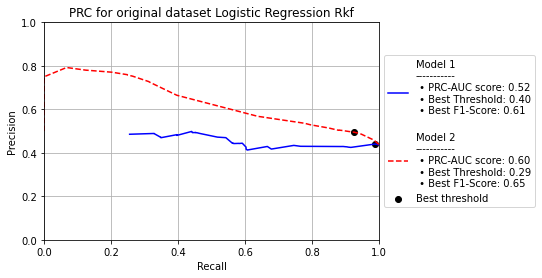

Best Threshold=0.294527, F1-Score=0.645 for model 1
Best Threshold=0.293940, F1-Score=0.645 for model 2


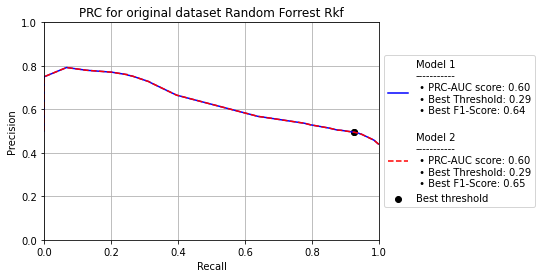

Best Threshold=0.292542, F1-Score=0.645 for model 1
Best Threshold=0.293618, F1-Score=0.645 for model 2


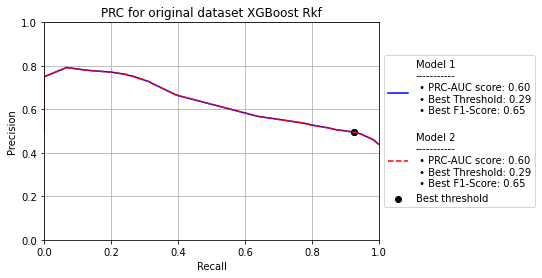

Best Threshold=0.470500, F1-Score=0.645 for model 1
Best Threshold=0.019129, F1-Score=0.600 for model 2


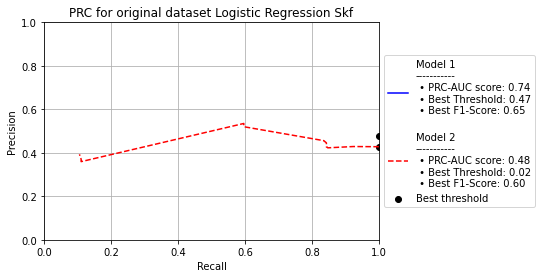

Best Threshold=1.000000, F1-Score=0.649 for model 1
Best Threshold=1.000000, F1-Score=0.649 for model 2


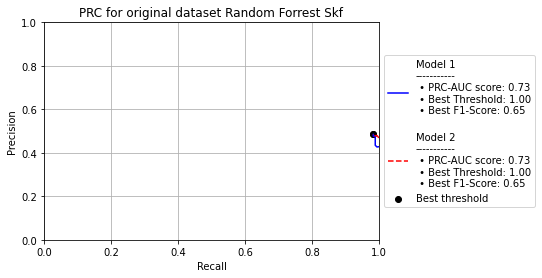

Best Threshold=0.997116, F1-Score=0.654 for model 1
Best Threshold=0.998933, F1-Score=0.652 for model 2


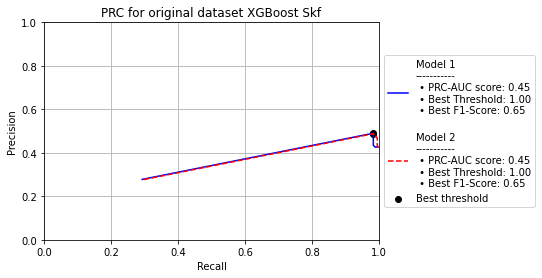

Best Threshold=0.001439, F1-Score=0.804 for model 1
Best Threshold=0.000032, F1-Score=0.804 for model 2


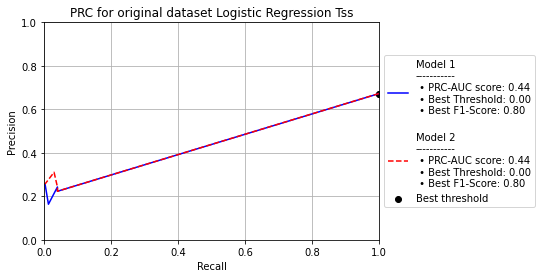

Best Threshold=0.000000, F1-Score=0.804 for model 1
Best Threshold=0.000000, F1-Score=0.804 for model 2


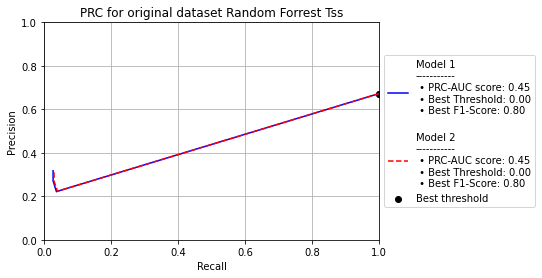

Best Threshold=0.000100, F1-Score=0.804 for model 1
Best Threshold=0.000080, F1-Score=0.804 for model 2


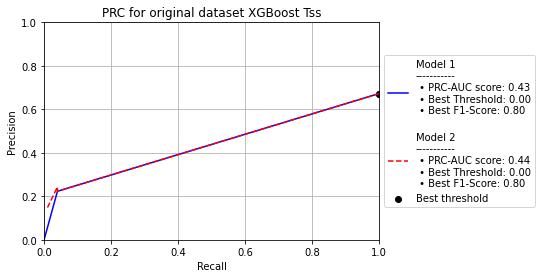

In [28]:
lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "original dataset Logistic Regression Rkf")
rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "original dataset Random Forrest Rkf")
xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "original dataset XGBoost Rkf")

lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "original dataset Logistic Regression Skf")
rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "original dataset Random Forrest Skf")
xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "original dataset XGBoost Skf")

lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "original dataset Logistic Regression Tss")
rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "original dataset Random Forrest Tss")
xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "original dataset XGBoost Tss")

### Rebalancing data

#### Undersampling

In [29]:
bug_df = graph_df.loc[graph_df['Bug'] == 1].sample(n=1900, random_state=42)
non_bug_df = graph_df.loc[graph_df['Bug'] == 0].sample(n=1900, random_state=42)
normalized_under_df = pd.concat([bug_df, non_bug_df])
normalized_under_df = normalized_under_df.reset_index()
print(normalized_under_df['Bug'].value_counts())

usx1 = normalized_under_df[labels1]
usx2 = normalized_under_df[labels2]
usy = normalized_under_df["Bug"]
usy = usy.sample(frac=1).reset_index(drop=True) # shuffle dataset

train, test = train_test_split(normalized_under_df, test_size=0.3, random_state = 5)

labels1 = ['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']
labels2 = set(list(normalized_under_df.columns))
labels2.difference_update(['index', 'Bug', 'Name', 'File', 'PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree'])

x1_train = train[labels1]
x2_train = train[labels2]
y_train = train["Bug"]
x1_test = test[labels1]
x2_test = test[labels2]
y_test = test["Bug"]

0    1900
1    1900
Name: Bug, dtype: int64


In [30]:
lr_model1.fit(x1_train, y_train)
lr_model2.fit(x2_train, y_train)
rf_model1.fit(x1_train, y_train)
rf_model2.fit(x2_train, y_train)
xgb_model1.fit(x1_train, y_train)
xgb_model2.fit(x2_train, y_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y_test)}")
results_data[18][0] = "Undersampled_Logistic_Regression"
results_data[18][1] = lr_model1.score(x1_test, y_test)
results_data[18][2] = lr_model2.score(x2_test, y_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y_test)}")
results_data[19][0] = "Undersampled_Random_Forrest"
results_data[19][1] = rf_model1.score(x1_test, y_test)
results_data[19][2] = rf_model2.score(x2_test, y_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y_test)}")
results_data[20][0] = "Undersampled_XGB_Classifier"
results_data[20][1] = xgb_model1.score(x1_test, y_test)
results_data[20][2] = xgb_model2.score(x2_test, y_test)

Logistic regression training score for model 1: 0.4692982456140351
Logistic regression training score for model 2: 0.6219298245614036
Random Forrest Classification training score for model 1: 0.6228070175438597
Random Forrest Classification training score for model 2: 0.6219298245614036
XGB Classifier training score for model 1: 0.6219298245614036
XGB Classifier training score for model 2: 0.6298245614035087


In [31]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[18][3] = acc1
results_data[18][4] = acc2
results_data[18][5] = prc_val1
results_data[18][6] = prc_val2
results_data[18][7] = pr_auc1
results_data[18][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[19][3] = acc1
results_data[19][4] = acc2
results_data[19][5] = prc_val1
results_data[19][6] = prc_val2
results_data[19][7] = pr_auc1
results_data[19][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[20][3] = acc1
results_data[20][4] = acc2
results_data[20][5] = prc_val1
results_data[20][6] = prc_val2
results_data[20][7] = pr_auc1
results_data[20][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.5210497303922323
Average Precision-Recall Score: 0.5206674339277423
PRC-AUC for model 1: 0.545072336818271
Accuracy: 0.469
Classification Report:

              precision    recall  f1-score   support

           0       0.47      0.31      0.37       583
           1       0.47      0.64      0.54       557

    accuracy                           0.47      1140
   macro avg       0.47      0.47      0.46      1140
weighted avg       0.47      0.47      0.45      1140


Scores for model 2
------------------
Roc_Auc Score: 0.6907163159661381
Average Precision-Recall Score: 0.6600051987856193
PRC-AUC for model 2: 0.6800604602710988
Classification Report:

              precision    recall  f1-score   support

           0       0.65      0.56      0.60       583
           1       0.60      0.68      0.64       557

    accuracy       

###### Compare Precision-Recall thresholds between models for undersampling

Best Threshold=0.481030, F1-Score=0.657 for model 1
Best Threshold=0.387112, F1-Score=0.695 for model 2


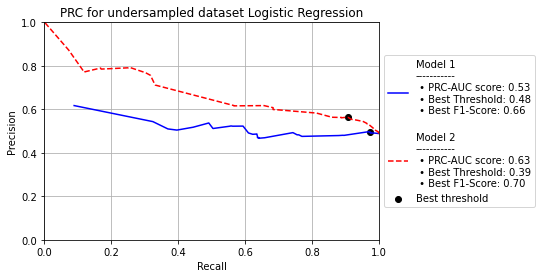

In [32]:
lr_best_threshold1, lr_best_threshold2, lr_us_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y_test, x2_test, y_test, lr_prediction_probs1, lr_prediction_probs2, "undersampled dataset Logistic Regression")

Best Threshold=0.398999, F1-Score=0.695 for model 1
Best Threshold=0.391803, F1-Score=0.694 for model 2


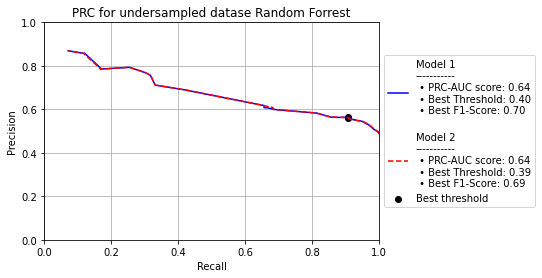

In [33]:
rf_best_threshold1, rf_best_threshold2, rf_us_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y_test, x2_test, y_test, rf_prediction_probs1, rf_prediction_probs2, "undersampled datase Random Forrest")

Best Threshold=0.398853, F1-Score=0.695 for model 1
Best Threshold=0.399616, F1-Score=0.695 for model 2


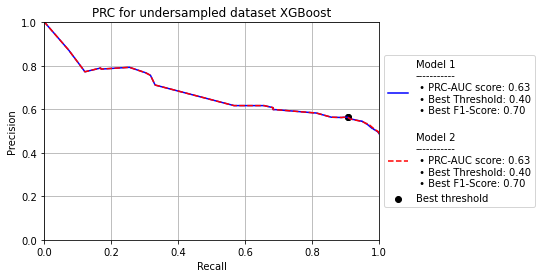

In [34]:
rf_best_threshold1, rf_best_threshold2, xgb_us_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y_test, x2_test, y_test, xgb_prediction_probs1, xgb_prediction_probs2, "undersampled dataset XGBoost")

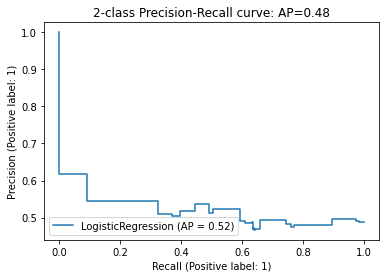

In [35]:
simple_threshold_plot(lr_model1, x1_test, y_test)

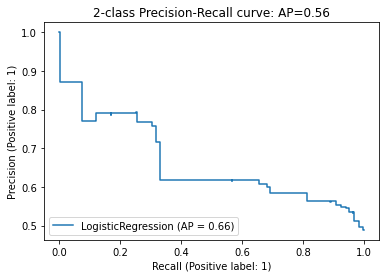

In [36]:
simple_threshold_plot(lr_model2, x2_test, y_test)

In [37]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[21][0] = "Undersampled_Logistic_Regression_Best_Threshold"
results_data[21][1] = lr_model1.score(x1_test, y_test)
results_data[21][2] = lr_model2.score(x2_test, y_test)
results_data[21][3] = acc1
results_data[21][4] = acc2
results_data[21][5] = prc_val1
results_data[21][6] = prc_val2
results_data[21][7] = pr_auc1
results_data[21][8] = pr_auc2

rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[22][0] = "Undersampled_Random_Forrest_Best_Threshold"
results_data[22][1] = rf_model1.score(x1_test, y_test)
results_data[22][2] = rf_model2.score(x2_test, y_test)
results_data[22][3] = acc1
results_data[22][4] = acc2
results_data[22][5] = prc_val1
results_data[22][6] = prc_val2
results_data[22][7] = pr_auc1
results_data[22][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[23][0] = "Undersampled_XGB_Classifier_Best_Threshold"
results_data[23][1] = xgb_model1.score(x1_test, y_test)
results_data[23][2] = xgb_model2.score(x2_test, y_test)
results_data[23][3] = acc1
results_data[23][4] = acc2
results_data[23][5] = prc_val1
results_data[23][6] = prc_val2
results_data[23][7] = pr_auc1
results_data[23][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.5210497303922323
Average Precision-Recall Score: 0.5206674339277423
PRC-AUC for model 1: 0.5327480111734699
Accuracy: 0.502
Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.05      0.09       583
           1       0.49      0.97      0.66       557

    accuracy                           0.50      1140
   macro avg       0.58      0.51      0.37      1140
weighted avg       0.59      0.50      0.37      1140


Scores for model 2
------------------
Roc_Auc Score: 0.6907163159661381
Average Precision-Recall Score: 0.6600051987856193
PRC-AUC for model 2: 0.6310266864353862
Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.33      0.46       583
           1       0.56      0.91      0.70       557

    accuracy                           0.61      1140
   macro avg       0.68      0.62      0.58      1140
weighted 

##### Cross Validation After Undersampling Rebalance for model 1

###### Repeated KFold

In [38]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1 = Rkf(lr_model1, usx1, usy)
results_data[24][0] = "Undersampled_Logistic_Regression_rkf"
results_data[24][1] = model_score
results_data[24][3] = acc
results_data[24][5] = prc_val
results_data[24][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1 = Rkf(lr_model1, usx1, usy, lr_best_threshold1)
results_data[25][0] = "Undersampled_Logistic_Regression_rkf_Best_Threshold"
results_data[25][1] = model_score
results_data[25][3] = acc
results_data[25][5] = prc_val
results_data[25][7] = pr_auc

Rkf_short(lr_model1, usx1, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1 = Rkf(rf_model1, usx1, usy)
results_data[26][0] = "Undersampled_Random_Forrest_rkf"
results_data[26][1] = model_score
results_data[26][3] = acc
results_data[26][5] = prc_val
results_data[26][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1 = Rkf(xgb_model1, usx1, usy)
results_data[27][0] = "Undersampled_XGB_Classifier_rkf"
results_data[27][1] = model_score
results_data[27][3] = acc
results_data[27][5] = prc_val
results_data[27][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [   4   11   16   19   35   36   38   46   50   75   89   90  114  116
  119  127  143  153  154  172  180  190  216  225  234  245  264  268
  284  301  335  356  369  395  396  399  412  417  469  487  496  499
  510  512  515  524  537  546  550  559  569  574  580  595  606  616
  625  633  635  639  652  656  658  675  681  684  699  703  713  717
  728  732  740  750  753  773  784  797  825  828  830  833  837  850
  851  853  872  876  884  895  896  920  953  954  957  959  971  977
  980  991  992  996 1008 1012 1015 1045 1060 1062 1065 1066 1069 1077
 1081 1092 1115 1119 1122 1126 1139 1141 1148 1150 1155 1156 1158 1166
 1167 1191 1197 1205 1209 1212 1217 1218 1219 1227 1243 1296 1300 1312
 1324 1346 1348 1365 1388 1409 1415 1416 1440 1470 1492 1504 1516 1519
 1527 1540 1542 1548 1568 1571 1595 1625 1630 1

In [39]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1 = Skf(lr_model1, usx1, usy)
results_data[28][0] = "Undersampled_Logistic_Regression_skf"
results_data[28][1] = model_score
results_data[28][3] = acc
results_data[28][5] = prc_val
results_data[28][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1 = Skf(lr_model1, usx1, usy, lr_best_threshold1)
results_data[29][0] = "Undersampled_Logistic_Regression_skf_Best_Threshold"
results_data[29][1] = model_score
results_data[29][3] = acc
results_data[29][5] = prc_val
results_data[29][7] = pr_auc

Skf_short(lr_model1, usx1, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1 = Skf(rf_model1, usx1, usy)
results_data[30][0] = "Undersampled_Random_Forrest_skf"
results_data[30][1] = model_score
results_data[30][3] = acc
results_data[30][5] = prc_val
results_data[30][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1 = Skf(xgb_model1, usx1, usy)
results_data[31][0] = "Undersampled_XGB_Classifier_skf"
results_data[31][1] = model_score
results_data[31][3] = acc
results_data[31][5] = prc_val
results_data[31][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [1499 1500 1501 1502 1506 1507 1512 1513 1516 1518 1519 1521 1523 1527
 1529 1530 1533 1534 1536 1538 1540 1541 1542 1543 1544 1545 1546 1547
 1548 1549 1550 1551 1552 1553 1554 1555 1556 1557 1558 1559 1560 1561
 1562 1563 1564 1565 1566 1567 1568 1569 1570 1571 1572 1573 1574 1575
 1576 1577 1578 1579 1580 1581 1582 1583 1584 1585 1586 1587 1588 1589
 1590 1591 1592 1593 1594 1595 1596 1597 1598 1599 1600 1601 1602 1603
 1604 1605 1606 1607 1608 1609 1610 1611 1612 1613 1614 1615 1616 1617
 1618 1619 1620 1621 1622 1623 1624 1625 1626 1627 1628 1629 1630 1631
 1632 1633 1634 1635 1636 1637 1638 1639 1640 1641 1642 1643 1644 1645
 1646 1647 1648 1649 1650 1651 1652 1653 1654 1655 1656 1657 1658 1659
 1660 1661 1662 1663 1664 1665 1666 1667 1668 1669 1670 1671 1672 1673
 1674 1675 1676 1677 1678 1679 1680 1681 1682 1

In [40]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1 = Tss(lr_model1, usx1, usy)
results_data[32][0] = "Undersampled_Logistic_Regression_tss"
results_data[32][1] = model_score
results_data[32][3] = acc
results_data[32][5] = prc_val
results_data[32][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1 = Tss(lr_model1, usx1, usy, lr_best_threshold1)
results_data[33][0] = "Undersampled_Logistic_Regression_tss_Best_Threshold"
results_data[33][1] = model_score
results_data[33][3] = acc
results_data[33][5] = prc_val
results_data[33][7] = pr_auc

Skf_short(lr_model1, usx1, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1 = Tss(rf_model1, usx1, usy)
results_data[34][0] = "Undersampled_Random_Forrest_tss"
results_data[34][1] = model_score
results_data[34][3] = acc
results_data[34][5] = prc_val
results_data[34][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1 = Tss(xgb_model1, usx1, usy)
results_data[35][0] = "Undersampled_XGB_Classifier_tss"
results_data[35][1] = model_score
results_data[35][3] = acc
results_data[35][5] = prc_val
results_data[35][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 3164 3165 3166] | TEST: [3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180
 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194
 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207 3208
 3209 3210 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220 3221 3222
 3223 3224 3225 3226 3227 3228 3229 3230 3231 3232 3233 3234 3235 3236
 3237 3238 3239 3240 3241 3242 3243 3244 3245 3246 3247 3248 3249 3250
 3251 3252 3253 3254 3255 3256 3257 3258 3259 3260 3261 3262 3263 3264
 3265 3266 3267 3268 3269 3270 3271 3272 3273 3274 3275 3276 3277 3278
 3279 3280 3281 3282 3283 3284 3285 3286 3287 3288 3289 3290 3291 3292
 3293 3294 3295 3296 3297 3298 3299 3300 3301 3302 3303 3304 3305 3306
 3307 3308 3309 3310 3311 3312 3313 3314 3315 3316 3317 3318 3319 3320
 3321 3322 3323 3324 3325 3326 3327 3328 3329 3

TRAIN: [   0    1    2 ... 1898 1899 1900] | TEST: [1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914
 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928
 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942
 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956
 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970
 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026
 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040
 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054
 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068
 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082
 2083 2084 2085 2086 2087 

##### Cross Validation After Undersampling Rebalance for model 2

In [41]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2 = Rkf(lr_model2, usx2, usy)
results_data[24][2] = model_score
results_data[24][4] = acc
results_data[24][6] = prc_val
results_data[24][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2 = Rkf(lr_model2, usx2, usy, lr_best_threshold2)
results_data[25][2] = model_score
results_data[25][4] = acc
results_data[25][6] = prc_val
results_data[25][8] = pr_auc

Rkf_short(lr_model2, usx2, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2 = Rkf(rf_model2, usx2, usy)
results_data[26][2] = model_score
results_data[26][4] = acc
results_data[26][6] = prc_val
results_data[26][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2 = Rkf(xgb_model2, usx2, usy)
results_data[27][2] = model_score
results_data[27][4] = acc
results_data[27][6] = prc_val
results_data[27][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [  10   12   30   35   38   47   52   71   89  108  109  128  142  148
  151  178  183  206  209  225  226  235  269  272  275  287  292  295
  307  327  336  359  386  405  416  423  446  459  464  471  485  497
  529  536  563  564  570  583  613  627  636  639  653  667  669  678
  687  698  721  724  732  765  776  779  780  782  795  804  826  829
  832  844  848  851  861  870  883  884  886  896  903  905  910  912
  915  917  925  935  939  941  944  951  952  967  971  975  978  984
 1000 1016 1028 1036 1037 1051 1052 1066 1067 1083 1086 1094 1095 1098
 1112 1117 1121 1141 1150 1186 1194 1204 1209 1218 1224 1229 1251 1252
 1256 1260 1262 1269 1273 1278 1291 1294 1305 1319 1332 1344 1350 1351
 1366 1378 1394 1398 1445 1447 1448 1462 1469 1490 1492 1494 1496 1504
 1517 1520 1574 1590 1591 1601 1602 1610 1612 1

In [42]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2 = Skf(lr_model2, usx2, usy)
results_data[28][2] = model_score
results_data[28][4] = acc
results_data[28][6] = prc_val
results_data[28][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2 = Skf(lr_model2, usx2, usy, lr_best_threshold2)
results_data[29][2] = model_score
results_data[29][4] = acc
results_data[29][6] = prc_val
results_data[29][8] = pr_auc

Skf_short(lr_model2, usx2, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2 = Skf(rf_model2, usx2, usy)
results_data[30][2] = model_score
results_data[30][4] = acc
results_data[30][6] = prc_val
results_data[30][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2 = Skf(xgb_model2, usx2, usy)
results_data[31][2] = model_score
results_data[31][4] = acc
results_data[31][6] = prc_val
results_data[31][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [ 375  376  377 ... 3797 3798 3799] | TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 

In [43]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2 = Tss(lr_model2, usx2, usy)
results_data[32][2] = model_score
results_data[32][4] = acc
results_data[32][6] = prc_val
results_data[32][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2 = Tss(lr_model2, usx2, usy, lr_best_threshold2)
results_data[33][2] = model_score
results_data[33][4] = acc
results_data[33][6] = prc_val
results_data[33][8] = pr_auc

Skf_short(lr_model2, usx2, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2 = Tss(rf_model2, usx2, usy)
results_data[34][2] = model_score
results_data[34][4] = acc
results_data[34][6] = prc_val
results_data[34][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2 = Tss(xgb_model2, usx2, usy)
results_data[35][2] = model_score
results_data[35][4] = acc
results_data[35][6] = prc_val
results_data[35][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 1898 1899 1900] | TEST: [1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914
 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928
 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942
 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956
 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970
 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026
 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040
 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054
 2055 2056 2057 2058 2059 2060 2061 2062 2063 2

TRAIN: [   0    1    2 ... 3164 3165 3166] | TEST: [3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180
 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194
 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207 3208
 3209 3210 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220 3221 3222
 3223 3224 3225 3226 3227 3228 3229 3230 3231 3232 3233 3234 3235 3236
 3237 3238 3239 3240 3241 3242 3243 3244 3245 3246 3247 3248 3249 3250
 3251 3252 3253 3254 3255 3256 3257 3258 3259 3260 3261 3262 3263 3264
 3265 3266 3267 3268 3269 3270 3271 3272 3273 3274 3275 3276 3277 3278
 3279 3280 3281 3282 3283 3284 3285 3286 3287 3288 3289 3290 3291 3292
 3293 3294 3295 3296 3297 3298 3299 3300 3301 3302 3303 3304 3305 3306
 3307 3308 3309 3310 3311 3312 3313 3314 3315 3316 3317 3318 3319 3320
 3321 3322 3323 3324 3325 3326 3327 3328 3329 3330 3331 3332 3333 3334
 3335 3336 3337 3338 3339 3340 3341 3342 3343 3344 3345 3346 3347 3348
 3349 3350 3351 3352 3353 

Best Threshold=0.473745, F1-Score=0.705 for model 1
Best Threshold=0.179846, F1-Score=0.715 for model 2


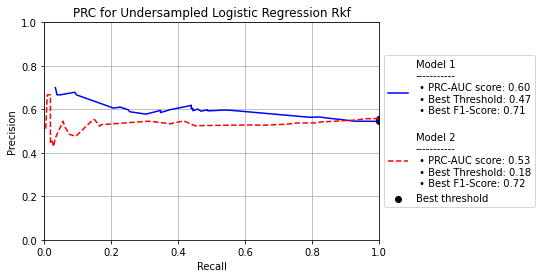

Best Threshold=0.224207, F1-Score=0.715 for model 1
Best Threshold=0.233459, F1-Score=0.715 for model 2


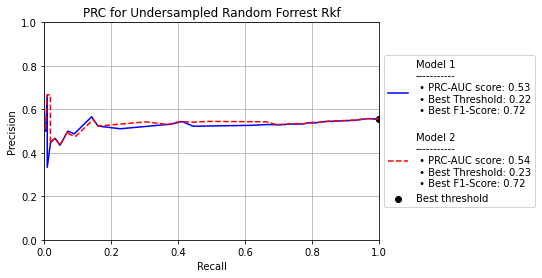

Best Threshold=0.196574, F1-Score=0.715 for model 1
Best Threshold=0.199668, F1-Score=0.715 for model 2


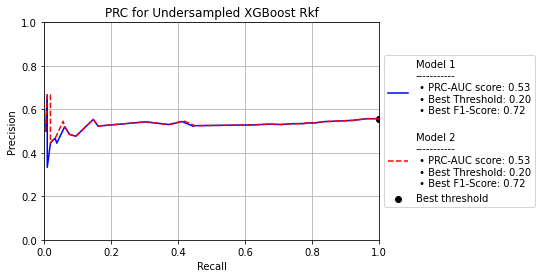

Best Threshold=0.477061, F1-Score=0.667 for model 1
Best Threshold=0.348635, F1-Score=0.667 for model 2


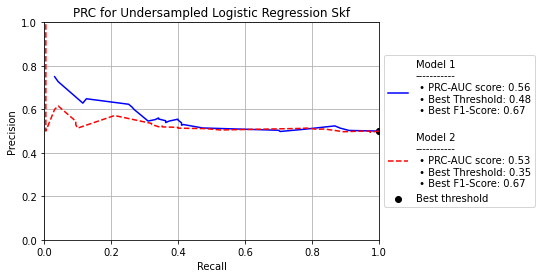

Best Threshold=0.205168, F1-Score=0.667 for model 1
Best Threshold=0.220093, F1-Score=0.667 for model 2


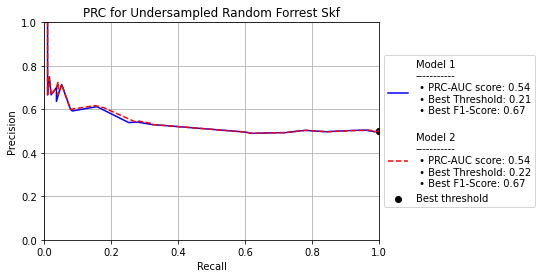

Best Threshold=0.346423, F1-Score=0.667 for model 1
Best Threshold=0.346320, F1-Score=0.667 for model 2


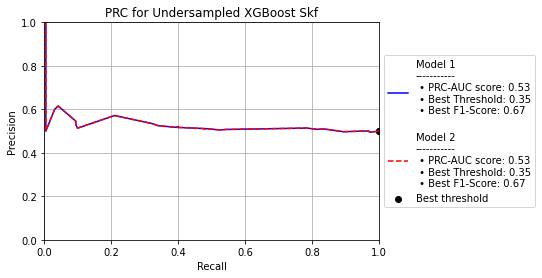

Best Threshold=0.485952, F1-Score=0.673 for model 1
Best Threshold=0.343728, F1-Score=0.680 for model 2


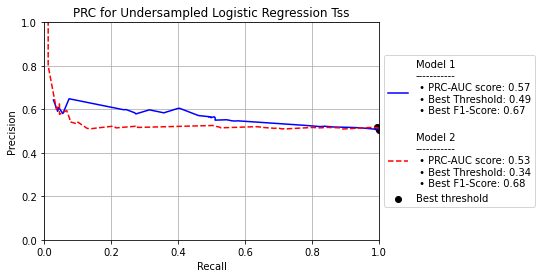

Best Threshold=0.307988, F1-Score=0.681 for model 1
Best Threshold=0.321430, F1-Score=0.681 for model 2


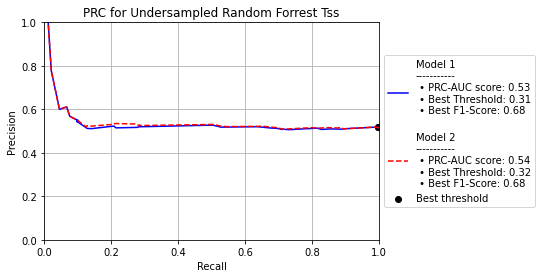

Best Threshold=0.334048, F1-Score=0.680 for model 1
Best Threshold=0.032752, F1-Score=0.673 for model 2


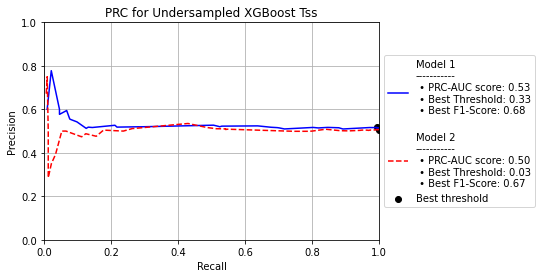

In [44]:
lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_us_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "Undersampled Logistic Regression Rkf")
rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_us_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "Undersampled Random Forrest Rkf")
xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_us_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "Undersampled XGBoost Rkf")

lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_us_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "Undersampled Logistic Regression Skf")
rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_us_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "Undersampled Random Forrest Skf")
xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_us_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "Undersampled XGBoost Skf")

lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_us_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "Undersampled Logistic Regression Tss")
rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_us_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "Undersampled Random Forrest Tss")
xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_us_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "Undersampled XGBoost Tss")

#### Oversampling

In [45]:
x1 = graph_df[labels1]
x2 = graph_df[labels2]
y = graph_df["Bug"]

In [46]:
# For oversampling we will use SMOTE (Synthetic Minority Over-sampling Technique)

# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

print("x1 Before SMOTE:")

print(x1_train.shape)

print("x2 Before SMOTE:")

print(x2_train.shape)

# Fit the model to generate the data for Model 1.
oversampled_X1, oversampled_Y1 = sm.fit_resample(x1, y)

# Fit the model to generate the data for Model 2.
oversampled_X2, oversampled_Y2 = sm.fit_resample(x2, y)

print("x1 After SMOTE:")

print(oversampled_X1.shape)

print("x2 After SMOTE:")

print(oversampled_X2.shape)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y1.value_counts(normalize=True) * 100)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y2.value_counts(normalize=True) * 100)

osx1 = oversampled_X1
osx2 = oversampled_X2
osy1 = oversampled_Y1
osy2 = oversampled_Y2

x1 Before SMOTE:
(2660, 5)
x2 Before SMOTE:
(2660, 129)
x1 After SMOTE:
(138102, 5)
x2 After SMOTE:
(138102, 129)

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64


In [47]:
x1_train, x1_test, y1_train, y1_test = train_test_split(osx1, osy1, test_size=0.3, random_state = 5)
#x1_train, y1_train = sm.fit_resample(x1_train, y1_train)
x2_train, x2_test, y2_train, y2_test = train_test_split(osx2, osy2, test_size=0.3, random_state = 5)
#x2_train, y2_train = sm.fit_resample(x2_train, y2_train)
lr_model1.fit(x1_train, y1_train)
lr_model2.fit(x2_train, y2_train)
rf_model1.fit(x1_train, y1_train)
rf_model2.fit(x2_train, y2_train)
xgb_model1.fit(x1_train, y1_train)
xgb_model2.fit(x2_train, y2_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y1_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y2_test)}")
results_data[36][0] = "Oversampled_Logistic_Regression"
results_data[36][1] = lr_model1.score(x1_test, y1_test)
results_data[36][2] = lr_model2.score(x2_test, y2_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y1_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y2_test)}")
results_data[37][0] = "Oversampled_Random_Forrest"
results_data[37][1] = rf_model1.score(x1_test, y1_test)
results_data[37][2] = rf_model2.score(x2_test, y2_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y1_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y2_test)}")
results_data[38][0] = "Oversampled_XGB_Classifier"
results_data[38][1] = xgb_model1.score(x1_test, y1_test)
results_data[38][2] = xgb_model2.score(x2_test, y2_test)

Logistic regression training score for model 1: 0.4912505129009679
Logistic regression training score for model 2: 0.6369385242934035
Random Forrest Classification training score for model 1: 0.6369626608095388
Random Forrest Classification training score for model 2: 0.6369626608095388
XGB Classifier training score for model 1: 0.6369626608095388
XGB Classifier training score for model 2: 0.6369626608095388


In [48]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[36][3] = acc1
results_data[36][4] = acc2
results_data[36][5] = prc_val1
results_data[36][6] = prc_val2
results_data[36][7] = pr_auc1
results_data[36][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[37][3] = acc1
results_data[37][4] = acc2
results_data[37][5] = prc_val1
results_data[37][6] = prc_val2
results_data[37][7] = pr_auc1
results_data[37][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[38][3] = acc1
results_data[38][4] = acc2
results_data[38][5] = prc_val1
results_data[38][6] = prc_val2
results_data[38][7] = pr_auc1
results_data[38][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.5248258545770456
Average Precision-Recall Score: 0.524899538443445
PRC-AUC for model 1: 0.5818185358532019
Accuracy: 0.491
Classification Report:

              precision    recall  f1-score   support

           0       0.49      0.34      0.40     20741
           1       0.49      0.65      0.56     20690

    accuracy                           0.49     41431
   macro avg       0.49      0.49      0.48     41431
weighted avg       0.49      0.49      0.48     41431


Scores for model 2
------------------
Roc_Auc Score: 0.697864954102974
Average Precision-Recall Score: 0.6724370981963607
PRC-AUC for model 2: 0.6874257305899103
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.63      0.64     20741
           1       0.64      0.64      0.64     20690

    accuracy        

In [49]:
y1_test.value_counts()

0    20741
1    20690
Name: Bug, dtype: int64

###### Compare Precision-Recall thresholds between models for oversampling

Best Threshold=0.474672, F1-Score=0.666 for model 1
Best Threshold=0.358784, F1-Score=0.698 for model 2


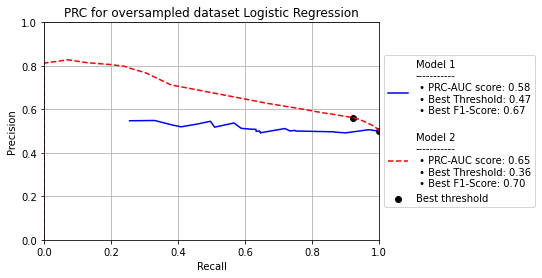

In [50]:
lr_best_threshold1, lr_best_threshold2, lr_os_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_test, x2_test, y2_test, lr_prediction_probs1, lr_prediction_probs2, "oversampled dataset Logistic Regression")

Best Threshold=0.357950, F1-Score=0.698 for model 1
Best Threshold=0.358520, F1-Score=0.698 for model 2


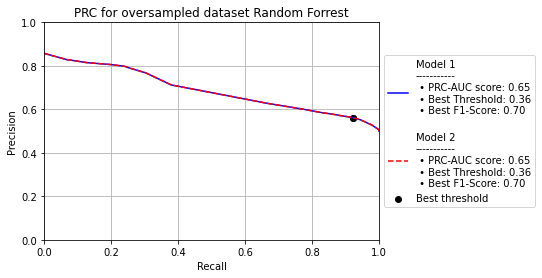

In [51]:
rf_best_threshold1, rf_best_threshold2, rf_os_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_test, x2_test, y2_test, rf_prediction_probs1, rf_prediction_probs2, "oversampled dataset Random Forrest")

Best Threshold=0.358139, F1-Score=0.698 for model 1
Best Threshold=0.359316, F1-Score=0.698 for model 2


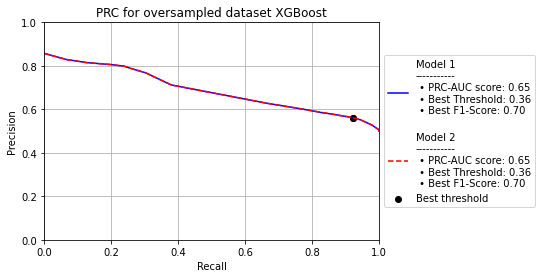

In [52]:
xgb_best_threshold1, xgb_best_threshold2, xgb_os_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_test, x2_test, y2_test, xgb_prediction_probs1, xgb_prediction_probs2, "oversampled dataset XGBoost")

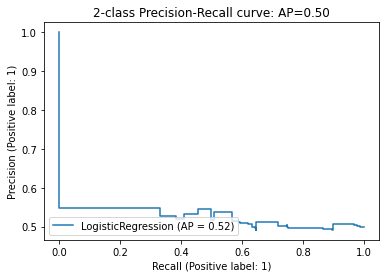

In [53]:
simple_threshold_plot(lr_model1, x1_test, y1_test)

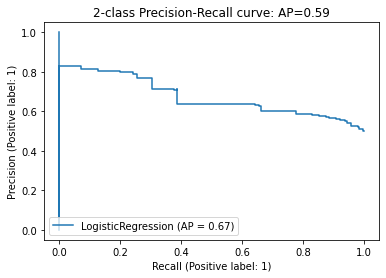

In [54]:
simple_threshold_plot(lr_model2, x2_test, y2_test)

Using best threshold...

In [55]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[39][0] = "Oversampled_Logistic_Regression_Best_Threshold"
results_data[39][1] = lr_model1.score(x1_test, y1_test)
results_data[39][2] = lr_model2.score(x2_test, y2_test)
results_data[39][3] = acc1
results_data[39][4] = acc2
results_data[39][5] = prc_val1
results_data[39][6] = prc_val2
results_data[39][7] = pr_auc1
results_data[39][8] = pr_auc2

rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[40][0] = "Oversampled_Logistic_Regression_Best_Threshold"
results_data[40][1] = rf_model1.score(x1_test, y1_test)
results_data[40][2] = rf_model2.score(x2_test, y2_test)
results_data[40][3] = acc1
results_data[40][4] = acc2
results_data[40][5] = prc_val1
results_data[40][6] = prc_val2
results_data[40][7] = pr_auc1
results_data[40][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[41][0] = "Oversampled_Logistic_Regression_Best_Threshold"
results_data[41][1] = xgb_model1.score(x1_test, y1_test)
results_data[41][2] = xgb_model2.score(x2_test, y2_test)
results_data[41][3] = acc1
results_data[41][4] = acc2
results_data[41][5] = prc_val1
results_data[41][6] = prc_val2
results_data[41][7] = pr_auc1
results_data[41][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.5248258545770456
Average Precision-Recall Score: 0.524899538443445
PRC-AUC for model 1: 0.5818185358532019
Accuracy: 0.499
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     20741
           1       0.50      1.00      0.67     20690

    accuracy                           0.50     41431
   macro avg       0.25      0.50      0.33     41431
weighted avg       0.25      0.50      0.33     41431


Scores for model 2
------------------
Roc_Auc Score: 0.697864954102974
Average Precision-Recall Score: 0.6724370981963607
PRC-AUC for model 2: 0.6461849359209868
Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.28      0.41     20741
           1       0.56      0.92      0.70     20690

    accuracy                           0.60     41431
   macro avg       0.67      0.60      0.55     41431
weighted av

##### Cross Validation After Oversampling Rebalance for model 1

In [56]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1 = Rkf(lr_model1, osx1, osy1)
results_data[42][0] = "Oversampled_Logistic_Regression_rkf"
results_data[42][1] = model_score
results_data[42][3] = acc
results_data[42][5] = prc_val
results_data[42][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1 = Rkf(lr_model1, osx1, osy1, lr_best_threshold1)
results_data[43][0] = "Oversampled_Logistic_Regression_rkf_Best_Threshold"
results_data[43][1] = model_score
results_data[43][3] = acc
results_data[43][5] = prc_val
results_data[43][7] = pr_auc

Rkf_short(lr_model1, osx1, osy1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1 = Rkf(rf_model1, osx1, osy1)
results_data[44][0] = "Oversampled_Random_Forrest_rkf"
results_data[44][1] = model_score
results_data[44][3] = acc
results_data[44][5] = prc_val
results_data[44][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1 = Rkf(xgb_model1, osx1, osy1)
results_data[45][0] = "Oversampled_XGB_Classifier_rkf"
results_data[45][1] = model_score
results_data[45][3] = acc
results_data[45][5] = prc_val
results_data[45][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.5146994931209269
Average Precision-Recall Score: 0.5161797831290482
PRC-AUC Score: 0.5945394817788564
Classification Report:

              precision    recall  f1-score   support

           0       0.51      0.38      0.44      6767
           1       0.52      0.64      0.57      7043

    accuracy                           0.51     13810
   macro avg       0.51      0.51      0.51     13810
weighted avg       0.51      0.51      0.51     13810

Accuracy: 0.515
---------------------
With best threshold
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.5146994931209269
Average Precision-Recall Score: 0.5161797831290482
PRC-AUC Score: 0.7549963794351919
Classificati

In [57]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1 = Skf(lr_model1, osx1, osy1)
results_data[46][0] = "Oversampled_Logistic_Regression_skf"
results_data[46][1] = model_score
results_data[46][3] = acc
results_data[46][5] = prc_val
results_data[46][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1 = Skf(lr_model1, osx1, osy1, lr_best_threshold1)
results_data[47][0] = "Oversampled_Logistic_Regression_skf_Best_Threshold"
results_data[47][1] = model_score
results_data[47][3] = acc
results_data[47][5] = prc_val
results_data[47][7] = pr_auc

Skf_short(lr_model1, osx1, osy1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1 = Skf(rf_model1, osx1, osy1)
results_data[48][0] = "Oversampled_Random_Forrest_skf"
results_data[48][1] = model_score
results_data[48][3] = acc
results_data[48][5] = prc_val
results_data[48][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1 = Skf(xgb_model1, osx1, osy1)
results_data[49][0] = "Oversampled_XGB_Classifier_skf"
results_data[49][1] = model_score
results_data[49][3] = acc
results_data[49][5] = prc_val
results_data[49][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [47202 47203 47204 ... 77456 77457 77458]

Model Score: 0.8060825488776249

Average Precision-Recall Score: 0.7205468016278828
PRC-AUC Score: 0.47229705713154535
Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.61      0.76      6905
           1       0.72      1.00      0.84      6905

    accuracy                           0.81     13810
   macro avg       0.86      0.81      0.80     13810
weighted avg       0.86      0.81      0.80     13810

Accuracy: 0.806
---------------------
With best threshold
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [47202 47203 47204 ... 77456 77457 77458]

Model Score: 0.8060825488776249

Average Precision-Recall Score: 0.7205468016278828
PRC-AUC Score: 0.75
Classification Report:

           

In [58]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1 = Tss(lr_model1, osx1, osy1)
results_data[50][0] = "Oversampled_Logistic_Regression_tss"
results_data[50][1] = model_score
results_data[50][3] = acc
results_data[50][5] = prc_val
results_data[50][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1 = Tss(lr_model1, osx1, osy1, lr_best_threshold1)
results_data[51][0] = "Oversampled_Logistic_Regression_tss_Best_Threshold"
results_data[51][1] = model_score
results_data[51][3] = acc
results_data[51][5] = prc_val
results_data[51][7] = pr_auc

Tss_short(lr_model1, osx1, osy1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1 = Tss(rf_model1, osx1, osy1)
results_data[52][0] = "Oversampled_Random_Forrest_tss"
results_data[52][1] = model_score
results_data[52][3] = acc
results_data[52][5] = prc_val
results_data[52][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1 = Tss(xgb_model1, osx1, osy1)
results_data[53][0] = "Oversampled_XGB_Classifier_tss"
results_data[53][1] = model_score
results_data[53][3] = acc
results_data[53][5] = prc_val
results_data[53][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.14728244341139157

Average Precision-Recall Score: 0.8527175565886084
PRC-AUC Score: 0.8562684391279823
Classification Report:

              precision    recall  f1-score   support

           0       0.15      1.00      0.26      3390
           1       0.00      0.00      0.00     19627

    accuracy                           0.15     23017
   macro avg       0.07      0.50      0.13     23017
weighted avg       0.02      0.15      0.04     23017

Accuracy: 0.147
---------------------
With best threshold
TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.14728244341139157

Average Precision-Recall Score: 0.8527175565886084
PRC-AUC Score: 0.9263587782943041
Classifi

##### Cross Validation After Oversampling Rebalance for model 2

In [59]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2 = Rkf(lr_model2, osx2, osy2)
results_data[42][2] = model_score
results_data[42][4] = acc
results_data[42][6] = prc_val
results_data[42][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2 = Rkf(lr_model2, osx2, osy2, lr_best_threshold2)
results_data[43][2] = model_score
results_data[43][4] = acc
results_data[43][6] = prc_val
results_data[43][8] = pr_auc

Rkf_short(lr_model2, osx2, osy2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2 = Rkf(rf_model2, osx2, osy2)
results_data[44][2] = model_score
results_data[44][4] = acc
results_data[44][6] = prc_val
results_data[44][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2 = Rkf(xgb_model2, osx2, osy2)
results_data[45][2] = model_score
results_data[45][4] = acc
results_data[45][6] = prc_val
results_data[45][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734382314902995
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.64      0.64      6767
           1       0.65      0.65      0.65      7043

    accuracy                           0.64     13810
   macro avg       0.64      0.64      0.64     13810
weighted avg       0.64      0.64      0.64     13810

Accuracy: 0.644
---------------------
With best threshold
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.7303054092506265
Classification

In [60]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2 = Skf(lr_model2, osx2, osy2)
results_data[46][2] = model_score
results_data[46][4] = acc
results_data[46][6] = prc_val
results_data[46][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2 = Skf(lr_model2, osx2, osy2, lr_best_threshold2)
results_data[47][2] = model_score
results_data[47][4] = acc
results_data[47][6] = prc_val
results_data[47][8] = pr_auc

Skf_short(lr_model2, osx2, osy2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2 = Skf(rf_model2, osx2, osy2)
results_data[48][2] = model_score
results_data[48][4] = acc
results_data[48][6] = prc_val
results_data[48][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2 = Skf(xgb_model1, osx1, osy1)
results_data[49][2] = model_score
results_data[49][4] = acc
results_data[49][6] = prc_val
results_data[49][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 7974  7975  7976 ... 36532 36533 36534]

Model Score: 0.5882991818115995

Average Precision-Recall Score: 0.5484434561626429
PRC-AUC Score: 0.773911516867433
Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.18      0.30      6905
           1       0.55      1.00      0.71      6906

    accuracy                           0.59     13811
   macro avg       0.77      0.59      0.50     13811
weighted avg       0.77      0.59      0.50     13811

Accuracy: 0.588
---------------------
With best threshold
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 7974  7975  7976 ... 36532 36533 36534]

Model Score: 0.5882991818115995

Average Precision-Recall Score: 0.5484434561626429
PRC-AUC Score: 0.7742217280813215
Classification Report:


In [61]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2 = Tss(lr_model2, osx2, osy2)
results_data[50][2] = model_score
results_data[50][4] = acc
results_data[50][6] = prc_val
results_data[50][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2 = Tss(lr_model2, osx2, osy2, lr_best_threshold2)
results_data[51][2] = model_score
results_data[51][4] = acc
results_data[51][6] = prc_val
results_data[51][8] = pr_auc

Tss_short(lr_model2, osx2, osy2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2 = Tss(rf_model2, osx2, osy2)
results_data[52][2] = model_score
results_data[52][4] = acc
results_data[52][6] = prc_val
results_data[52][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2 = Tss(xgb_model2, osx2, osy2)
results_data[53][2] = model_score
results_data[53][4] = acc
results_data[53][6] = prc_val
results_data[53][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.3663813702915237

Average Precision-Recall Score: 0.810671142625063
PRC-AUC Score: 0.8085948538227488
Classification Report:

              precision    recall  f1-score   support

           0       0.06      0.23      0.10      3390
           1       0.75      0.39      0.51     19627

    accuracy                           0.37     23017
   macro avg       0.40      0.31      0.30     23017
weighted avg       0.64      0.37      0.45     23017

Accuracy: 0.366
---------------------
With best threshold
TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.3663813702915237

Average Precision-Recall Score: 0.810671142625063
PRC-AUC Score: 0.9162045156691385
Classificati

Best Threshold=0.478372, F1-Score=0.675 for model 1
Best Threshold=0.337162, F1-Score=0.712 for model 2


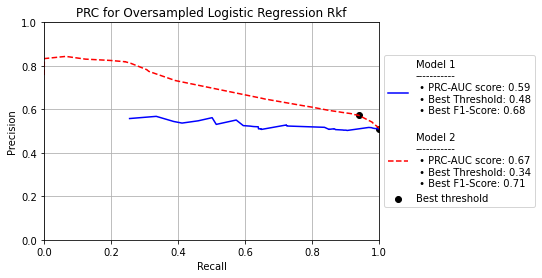

Best Threshold=0.336661, F1-Score=0.711 for model 1
Best Threshold=0.337727, F1-Score=0.711 for model 2


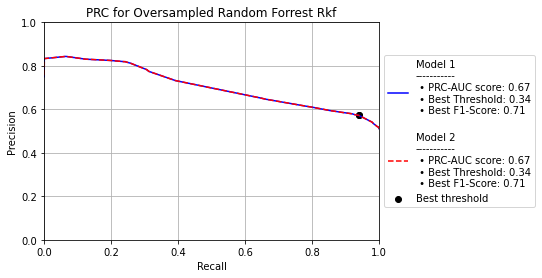

Best Threshold=0.337400, F1-Score=0.711 for model 1
Best Threshold=0.337547, F1-Score=0.711 for model 2


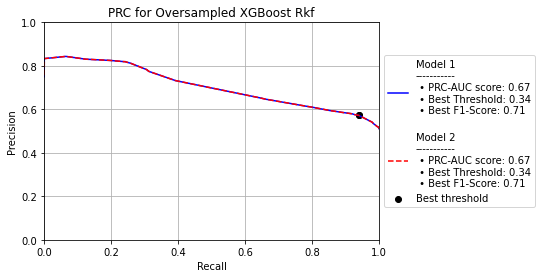

Best Threshold=0.501221, F1-Score=0.843 for model 1
Best Threshold=0.538804, F1-Score=0.708 for model 2


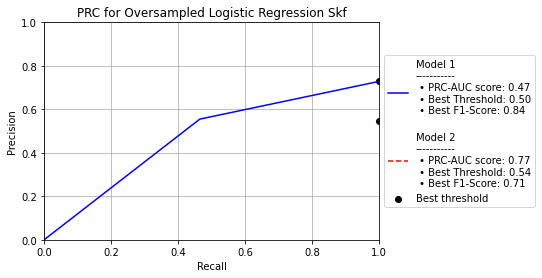

Best Threshold=0.538395, F1-Score=0.708 for model 1
Best Threshold=0.539375, F1-Score=0.708 for model 2


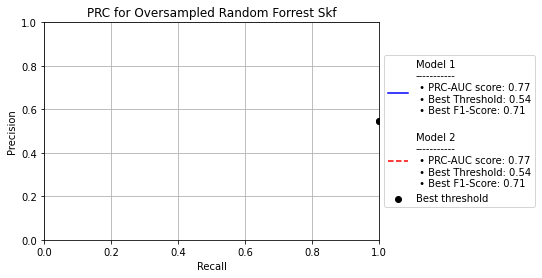

Best Threshold=0.538778, F1-Score=0.708 for model 1
Best Threshold=0.538778, F1-Score=0.708 for model 2


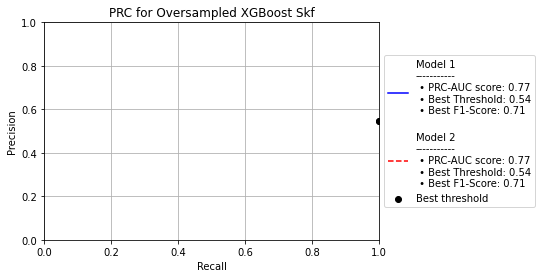

Best Threshold=0.395542, F1-Score=0.921 for model 1
Best Threshold=0.125846, F1-Score=0.927 for model 2


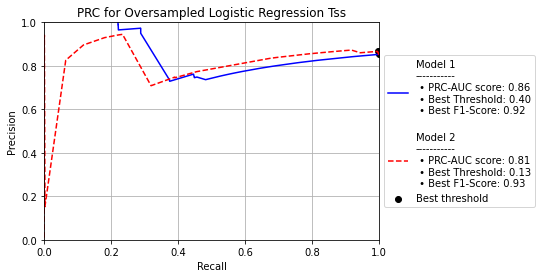

Best Threshold=0.123610, F1-Score=0.928 for model 1
Best Threshold=0.015005, F1-Score=0.921 for model 2


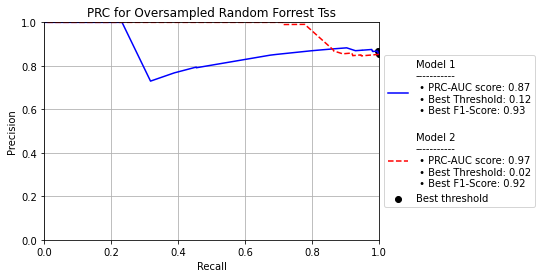

Best Threshold=0.125279, F1-Score=0.931 for model 1
Best Threshold=0.014874, F1-Score=0.921 for model 2


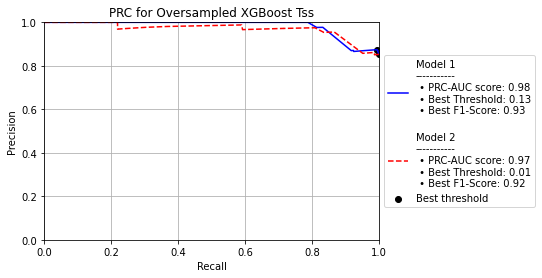

In [62]:
lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_os_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "Oversampled Logistic Regression Rkf")
rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_os_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "Oversampled Random Forrest Rkf")
xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_os_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "Oversampled XGBoost Rkf")

lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_os_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "Oversampled Logistic Regression Skf")
rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_os_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "Oversampled Random Forrest Skf")
xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_os_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "Oversampled XGBoost Skf")

lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_os_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "Oversampled Logistic Regression Tss")
rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_os_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "Oversampled Random Forrest Tss")
xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_os_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "Oversampled XGBoost Tss")

##### Combining Oversampling with Undersampling

In [63]:
x1 = graph_df[labels1]
x2 = graph_df[labels2]
y = graph_df["Bug"]

In [64]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
print("x1 Before SMOTE:")
print(x1.shape)
print("x2 Before SMOTE:")
print(x2.shape)

# Fit the model to generate the data for Model 1.
oversampled_X1, oversampled_Y1 = sm.fit_resample(x1, y)

# Fit the model to generate the data for Model 2.
oversampled_X2, oversampled_Y2 = sm.fit_resample(x2, y)

print("x1 After SMOTE:")
print(oversampled_X1.shape)
print("x2 After SMOTE:")
print(oversampled_X2.shape)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y1.value_counts(normalize=True) * 100)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y2.value_counts(normalize=True) * 100)

osx1 = oversampled_X1
osx2 = oversampled_X2
osy1 = oversampled_Y1
osy2 = oversampled_Y2

x1 Before SMOTE:
(120730, 5)
x2 Before SMOTE:
(120730, 129)
x1 After SMOTE:
(138102, 5)
x2 After SMOTE:
(138102, 129)

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64


In [65]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

print("x1 Before RandomUnderSampler:")
print(osx1.shape)
print("x2 Before RandomUnderSampler:")
print(osx2.shape)

balanced_x1, balanced_y1, = rus.fit_resample(osx1, osy1)
balanced_x2, balanced_y2, = rus.fit_resample(osx2, osy2)

print("x1 After RandomUnderSampler:")
print(balanced_x1.shape)
print("x2 After RandomUnderSampler:")
print(balanced_x1.shape)

print('\nBalance of positive and negative classes (%):')
print(balanced_y1.value_counts(normalize=True) * 100)

print('\nBalance of positive and negative classes (%):')
print(balanced_y2.value_counts(normalize=True) * 100)

x1 Before RandomUnderSampler:
(138102, 5)
x2 Before RandomUnderSampler:
(138102, 129)
x1 After RandomUnderSampler:
(138102, 5)
x2 After RandomUnderSampler:
(138102, 5)

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64


In [66]:
x1_train, x1_test, y1_train, y1_test = train_test_split(balanced_x1, balanced_y1, test_size=0.3, random_state = 5)
#x1_train, y1_train = sm.fit_resample(x1_train, y1_train)
x2_train, x2_test, y2_train, y2_test = train_test_split(balanced_x2, balanced_y2, test_size=0.3, random_state = 5)
#x2_train, y2_train = sm.fit_resample(x2_train, y2_train)
lr_model1.fit(x1_train, y1_train)
lr_model2.fit(x2_train, y2_train)
rf_model1.fit(x1_train, y1_train)
rf_model2.fit(x2_train, y2_train)
xgb_model1.fit(x1_train, y1_train)
xgb_model2.fit(x2_train, y2_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y1_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y2_test)}")
results_data[54][0] = "OSUS_Combination_Logistic_Regression"
results_data[54][1] = lr_model1.score(x1_test, y1_test)
results_data[54][2] = lr_model2.score(x2_test, y2_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y1_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y2_test)}")
results_data[55][0] = "OSUS_Combination_Random_Forrest"
results_data[55][1] = rf_model1.score(x1_test, y1_test)
results_data[55][2] = rf_model2.score(x2_test, y2_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y1_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y2_test)}")
results_data[56][0] = "OSUS_Combination_XGB_Classifier"
results_data[56][1] = xgb_model1.score(x1_test, y1_test)
results_data[56][2] = xgb_model2.score(x2_test, y2_test)

Logistic regression training score for model 1: 0.5184040935531365
Logistic regression training score for model 2: 0.6381936231324371
Random Forrest Classification training score for model 1: 0.6382418961647076
Random Forrest Classification training score for model 2: 0.6382418961647076
XGB Classifier training score for model 1: 0.6382418961647076
XGB Classifier training score for model 2: 0.6382418961647076


In [67]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[54][3] = acc1
results_data[54][4] = acc2
results_data[54][5] = prc_val1
results_data[54][6] = prc_val2
results_data[54][7] = pr_auc1
results_data[54][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[55][3] = acc1
results_data[55][4] = acc2
results_data[55][5] = prc_val1
results_data[55][6] = prc_val2
results_data[55][7] = pr_auc1
results_data[55][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[56][3] = acc1
results_data[56][4] = acc2
results_data[56][5] = prc_val1
results_data[56][6] = prc_val2
results_data[56][7] = pr_auc1
results_data[56][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.5266582501162582
Average Precision-Recall Score: 0.5245786652431242
PRC-AUC for model 1: 0.5812159742550034
Accuracy: 0.518
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.21      0.30     20751
           1       0.51      0.83      0.63     20680

    accuracy                           0.52     41431
   macro avg       0.53      0.52      0.47     41431
weighted avg       0.53      0.52      0.47     41431


Scores for model 2
------------------
Roc_Auc Score: 0.7019720577890166
Average Precision-Recall Score: 0.6755296567498528
PRC-AUC for model 2: 0.6885645811315209
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.63      0.64     20751
           1       0.64      0.64      0.64     20680

    accuracy      

###### Compare Precision-Recall thresholds between models for oversampling and undersampling combination

Best Threshold=0.482111, F1-Score=0.666 for model 1
Best Threshold=0.354572, F1-Score=0.701 for model 2


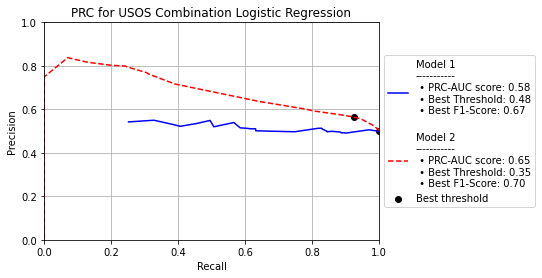

In [68]:
lr_best_threshold1, lr_best_threshold2, lr_osus_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_test, x2_test, y2_test, lr_prediction_probs1, lr_prediction_probs2, "USOS Combination Logistic Regression")

Best Threshold=0.355554, F1-Score=0.701 for model 1
Best Threshold=0.356548, F1-Score=0.701 for model 2


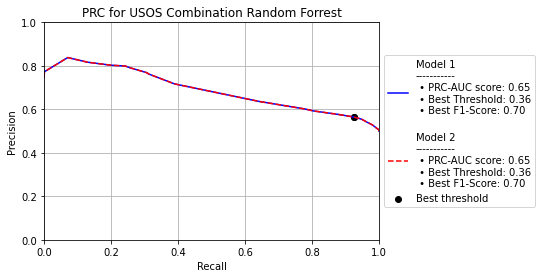

In [69]:
rf_best_threshold1, rf_best_threshold2, rf_osus_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_test, x2_test, y2_test, rf_prediction_probs1, rf_prediction_probs2, "USOS Combination Random Forrest")

Best Threshold=0.353626, F1-Score=0.701 for model 1
Best Threshold=0.355051, F1-Score=0.701 for model 2


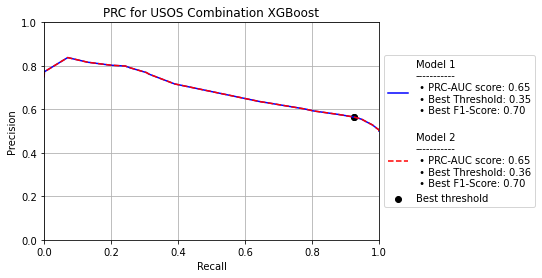

In [70]:
xgb_best_threshold1, xgb_best_threshold2, xgb_osus_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_test, x2_test, y2_test, xgb_prediction_probs1, xgb_prediction_probs2, "USOS Combination XGBoost")

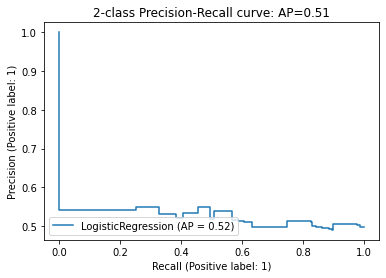

In [71]:
simple_threshold_plot(lr_model1, x1_test, y1_test)

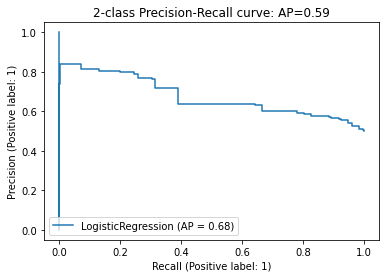

In [72]:
simple_threshold_plot(lr_model2, x2_test, y2_test)

Using the best threshold...

In [73]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[57][0] = "OSUS_Logistic_Regression_Best_Threshold"
results_data[57][1] = lr_model1.score(x1_test, y1_test)
results_data[57][2] = lr_model2.score(x2_test, y2_test)
results_data[57][3] = acc1
results_data[57][4] = acc2
results_data[57][5] = prc_val1
results_data[57][6] = prc_val2
results_data[57][7] = pr_auc1
results_data[57][8] = pr_auc2

rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[58][0] = "OSUS_Random_Forrest_Best_Threshold"
results_data[58][1] = rf_model1.score(x1_test, y1_test)
results_data[58][2] = rf_model2.score(x2_test, y2_test)
results_data[58][3] = acc1
results_data[58][4] = acc2
results_data[58][5] = prc_val1
results_data[58][6] = prc_val2
results_data[58][7] = pr_auc1
results_data[58][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[59][0] = "OSUS_XGBoost_Classifier_Best_Threshold"
results_data[59][1] = xgb_model1.score(x1_test, y1_test)
results_data[59][2] = xgb_model2.score(x2_test, y2_test)
results_data[59][3] = acc1
results_data[59][4] = acc2
results_data[59][5] = prc_val1
results_data[59][6] = prc_val2
results_data[59][7] = pr_auc1
results_data[59][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.5266582501162582
Average Precision-Recall Score: 0.5245786652431242
PRC-AUC for model 1: 0.5812159742550034
Accuracy: 0.499
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     20751
           1       0.50      1.00      0.67     20680

    accuracy                           0.50     41431
   macro avg       0.25      0.50      0.33     41431
weighted avg       0.25      0.50      0.33     41431


Scores for model 2
------------------
Roc_Auc Score: 0.7019720577890166
Average Precision-Recall Score: 0.6755296567498528
PRC-AUC for model 2: 0.6492083607226925
Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.28      0.42     20751
           1       0.56      0.93      0.70     20680

    accuracy                           0.61     41431
   macro avg       0.68      0.61      0.56     41431
weighted 

##### Cross Validation After Oversampling/Undersampling Combination Rebalance for model 1

In [74]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1 = Rkf(lr_model1, balanced_x1, balanced_y1)
results_data[60][0] = "OSUS_Combination_Logistic_Regression_rkf"
results_data[60][1] = model_score
results_data[60][3] = acc
results_data[60][5] = prc_val
results_data[60][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1 = Rkf(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
results_data[61][0] = "OSUS_Combination_Logistic_Regression_rkf_Best_Threshold"
results_data[61][1] = model_score
results_data[61][3] = acc
results_data[61][5] = prc_val
results_data[61][7] = pr_auc

Rkf_short(lr_model1, balanced_x1, balanced_y1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1 = Rkf(rf_model1, balanced_x1, balanced_y1)
results_data[62][0] = "OSUS_Combination_Random_Forrest_rkf"
results_data[62][1] = model_score
results_data[62][3] = acc
results_data[62][5] = prc_val
results_data[62][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1 = Rkf(xgb_model1, balanced_x1, balanced_y1)
results_data[63][0] = "OSUS_Combination_XGB_Classifier_rkf"
results_data[63][1] = model_score
results_data[63][3] = acc
results_data[63][5] = prc_val
results_data[63][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 138097 138100 138101] | TEST: [    29     38     52 ... 138073 138098 138099]

Model Score: 0.5278783490224475
Average Precision-Recall Score: 0.5122162707222828
PRC-AUC Score: 0.573980874933674
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.33      0.42      6945
           1       0.52      0.72      0.60      6865

    accuracy                           0.53     13810
   macro avg       0.53      0.53      0.51     13810
weighted avg       0.53      0.53      0.51     13810

Accuracy: 0.528
---------------------
With best threshold
TRAIN: [     0      1      2 ... 138097 138100 138101] | TEST: [    29     38     52 ... 138073 138098 138099]

Model Score: 0.5278783490224475
Average Precision-Recall Score: 0.5122162707222828
PRC-AUC Score: 0.7397857361691671
Classificatio

In [75]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1 = Skf(lr_model1, balanced_x1, balanced_y1)
results_data[64][0] = "OSUS_Combination_Logistic_Regression_skf"
results_data[64][1] = model_score
results_data[64][3] = acc
results_data[64][5] = prc_val
results_data[64][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1 = Skf(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
results_data[65][0] = "OSUS_Combination_Logistic_Regression_skf_Best_Threshold"
results_data[65][1] = model_score
results_data[65][3] = acc
results_data[65][5] = prc_val
results_data[65][7] = pr_auc

Skf_short(lr_model1, balanced_x1, balanced_y1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1 = Skf(rf_model1, balanced_x1, balanced_y1)
results_data[66][0] = "OSUS_Combination_Random_Forrest_skf"
results_data[66][1] = model_score
results_data[66][3] = acc
results_data[66][5] = prc_val
results_data[66][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1 = Skf(xgb_model1, balanced_x1, balanced_y1)
results_data[67][0] = "OSUS_Combination_XGB_Classifier_skf"
results_data[67][1] = model_score
results_data[67][3] = acc
results_data[67][5] = prc_val
results_data[67][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 55241  55242  55243 ... 131194 131195 131196]

Model Score: 0.5394641564083997

Average Precision-Recall Score: 0.5210668160248886
PRC-AUC Score: 0.5627667183188373
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.46      0.50      6905
           1       0.53      0.62      0.57      6905

    accuracy                           0.54     13810
   macro avg       0.54      0.54      0.54     13810
weighted avg       0.54      0.54      0.54     13810

Accuracy: 0.539
---------------------
With best threshold
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 55241  55242  55243 ... 131194 131195 131196]

Model Score: 0.5394641564083997

Average Precision-Recall Score: 0.5210668160248886
PRC-AUC Score: 0.7374385330473852
Classifica

In [76]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1 = Tss(lr_model1, balanced_x1, balanced_y1)
results_data[68][0] = "OSUS_Combination_Logistic_Regression_tss"
results_data[68][1] = model_score
results_data[68][3] = acc
results_data[68][5] = prc_val
results_data[68][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1 = Tss(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
results_data[69][0] = "OSUS_Combination_Logistic_Regression_tss_Best_Threshold"
results_data[69][1] = model_score
results_data[69][3] = acc
results_data[69][5] = prc_val
results_data[69][7] = pr_auc

Tss_short(lr_model1, balanced_x1, balanced_y1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1 = Skf(rf_model1, balanced_x1, balanced_y1)
results_data[70][0] = "OSUS_Combination_Random_Forrest_tss"
results_data[70][1] = model_score
results_data[70][3] = acc
results_data[70][5] = prc_val
results_data[70][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1 = Tss(xgb_model1, balanced_x1, balanced_y1)
results_data[71][0] = "OSUS_Combination_XGB_Classifier_tss"
results_data[71][1] = model_score
results_data[71][3] = acc
results_data[71][5] = prc_val
results_data[71][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 92065 92066 92067] | TEST: [ 92068  92069  92070 ... 115082 115083 115084]

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00   23017.0

    accuracy                           0.00   23017.0
   macro avg       0.00      0.00      0.00   23017.0
weighted avg       0.00      0.00      0.00   23017.0

Accuracy: 0.000
---------------------
With best threshold
TRAIN: [    0     1     2 ... 92065 92066 92067] | TEST: [ 92068  92069  92070 ... 115082 115083 115084]

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00

##### Cross Validation After Oversampling/Undersampling Combination Rebalance for model 2

In [77]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2 = Rkf(lr_model2, balanced_x2, balanced_y2)
results_data[60][2] = model_score
results_data[60][4] = acc
results_data[60][6] = prc_val
results_data[60][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2 = Rkf(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
results_data[61][2] = model_score
results_data[61][4] = acc
results_data[61][6] = prc_val
results_data[61][8] = pr_auc

Rkf_short(lr_model2, balanced_x2, balanced_y2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2 = Rkf(rf_model2, balanced_x2, balanced_y2)
results_data[62][2] = model_score
results_data[62][4] = acc
results_data[62][6] = prc_val
results_data[62][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2 = Rkf(xgb_model2, balanced_x2, balanced_y2)
results_data[63][2] = model_score
results_data[63][4] = acc
results_data[63][6] = prc_val
results_data[63][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      2      3 ... 138099 138100 138101] | TEST: [     1      7     12 ... 138073 138090 138098]

Model Score: 0.6420709630702389
Average Precision-Recall Score: 0.597485579456884
PRC-AUC Score: 0.6540158646815308
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.64      0.64      6809
           1       0.65      0.65      0.65      7001

    accuracy                           0.64     13810
   macro avg       0.64      0.64      0.64     13810
weighted avg       0.64      0.64      0.64     13810

Accuracy: 0.642
---------------------
With best threshold
TRAIN: [     0      2      3 ... 138099 138100 138101] | TEST: [     1      7     12 ... 138073 138090 138098]

Model Score: 0.6420709630702389
Average Precision-Recall Score: 0.597485579456884
PRC-AUC Score: 0.7243318171129576
Classification

In [78]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2 = Skf(lr_model2, balanced_x2, balanced_y2)
results_data[64][2] = model_score
results_data[64][4] = acc
results_data[64][6] = prc_val
results_data[64][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2 = Skf(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
results_data[65][2] = model_score
results_data[65][4] = acc
results_data[65][6] = prc_val
results_data[65][8] = pr_auc

Skf_short(lr_model2, balanced_x2, balanced_y2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2 = Skf(rf_model2, balanced_x2, balanced_y2)
results_data[66][2] = model_score
results_data[66][4] = acc
results_data[66][6] = prc_val
results_data[66][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2 = Skf(xgb_model2, balanced_x2, balanced_y2)
results_data[67][2] = model_score
results_data[67][4] = acc
results_data[67][6] = prc_val
results_data[67][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 48336  48337  48338 ... 124289 124290 124291]

Model Score: 0.5788559015206373

Average Precision-Recall Score: 0.5444038504448692
PRC-AUC Score: 0.44200803559345797
Classification Report:

              precision    recall  f1-score   support

           0       0.61      0.45      0.52      6905
           1       0.56      0.70      0.63      6905

    accuracy                           0.58     13810
   macro avg       0.58      0.58      0.57     13810
weighted avg       0.58      0.58      0.57     13810

Accuracy: 0.579
---------------------
With best threshold
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 48336  48337  48338 ... 124289 124290 124291]

Model Score: 0.5788559015206373

Average Precision-Recall Score: 0.5444038504448692
PRC-AUC Score: 0.7228955280138517
Classific

In [79]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2 = Tss(lr_model2, balanced_x2, balanced_y2)
results_data[68][2] = model_score
results_data[68][4] = acc
results_data[68][6] = prc_val
results_data[68][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2 = Tss(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
results_data[69][2] = model_score
results_data[69][4] = acc
results_data[69][6] = prc_val
results_data[69][8] = pr_auc

Tss_short(lr_model2, balanced_x2, balanced_y2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2 = Skf(rf_model2, balanced_x2, balanced_y2)
results_data[70][2] = model_score
results_data[70][4] = acc
results_data[70][6] = prc_val
results_data[70][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2 = Tss(xgb_model2, balanced_x2, balanced_y2)
results_data[71][2] = model_score
results_data[71][4] = acc
results_data[71][6] = prc_val
results_data[71][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 92065 92066 92067] | TEST: [ 92068  92069  92070 ... 115082 115083 115084]

Model Score: 0.24395012382152323

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.24      0.39     23017

    accuracy                           0.24     23017
   macro avg       0.50      0.12      0.20     23017
weighted avg       1.00      0.24      0.39     23017

Accuracy: 0.244
---------------------
With best threshold
TRAIN: [    0     1     2 ... 92065 92066 92067] | TEST: [ 92068  92069  92070 ... 115082 115083 115084]

Model Score: 0.24395012382152323

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

 

Best Threshold=0.483337, F1-Score=0.664 for model 1
Best Threshold=0.376645, F1-Score=0.704 for model 2


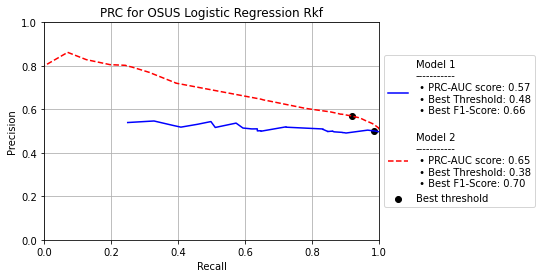

Best Threshold=0.374736, F1-Score=0.704 for model 1
Best Threshold=0.377652, F1-Score=0.704 for model 2


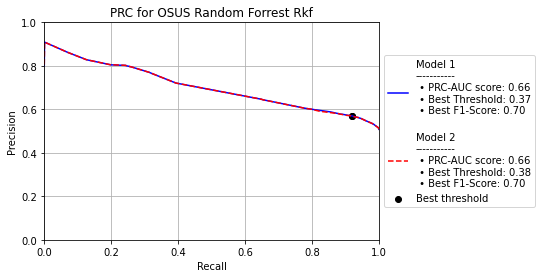

Best Threshold=0.377510, F1-Score=0.704 for model 1
Best Threshold=0.376471, F1-Score=0.704 for model 2


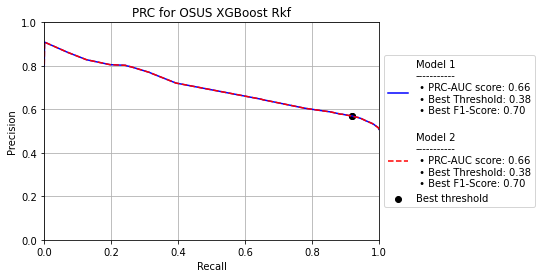

Best Threshold=0.462093, F1-Score=0.667 for model 1
Best Threshold=0.455313, F1-Score=0.702 for model 2


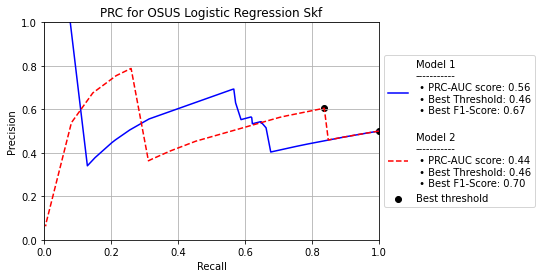

Best Threshold=0.455203, F1-Score=0.702 for model 1
Best Threshold=0.455906, F1-Score=0.702 for model 2


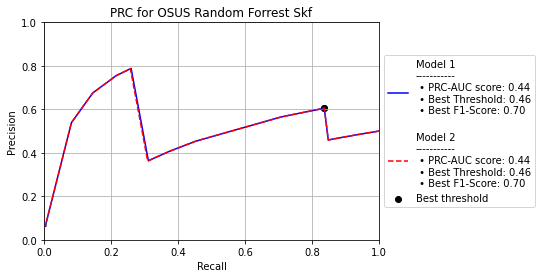

Best Threshold=0.455337, F1-Score=0.702 for model 1
Best Threshold=0.455280, F1-Score=0.702 for model 2


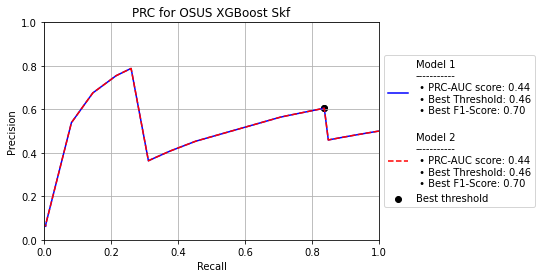

Best Threshold=0.210929, F1-Score=1.000 for model 1
Best Threshold=0.006741, F1-Score=1.000 for model 2


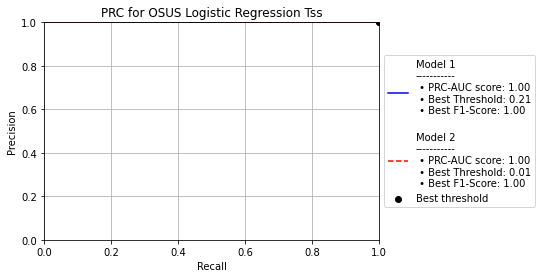

Best Threshold=0.454808, F1-Score=0.702 for model 1
Best Threshold=0.455220, F1-Score=0.702 for model 2


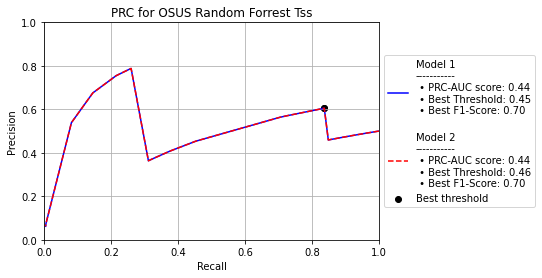

Best Threshold=0.004337, F1-Score=1.000 for model 1
Best Threshold=0.005925, F1-Score=1.000 for model 2


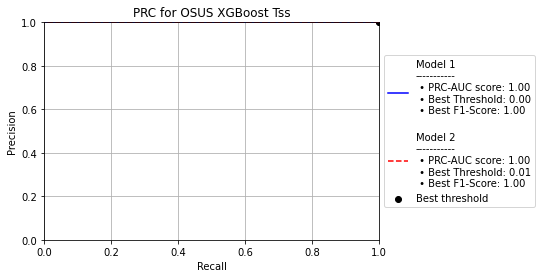

In [80]:
lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_osus_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "OSUS Logistic Regression Rkf")
rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_osus_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "OSUS Random Forrest Rkf")
xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_osus_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "OSUS XGBoost Rkf")

lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_osus_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "OSUS Logistic Regression Skf")
rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_osus_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "OSUS Random Forrest Skf")
xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_osus_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "OSUS XGBoost Skf")

lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_osus_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "OSUS Logistic Regression Tss")
rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_osus_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "OSUS Random Forrest Tss")
xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_osus_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "OSUS XGBoost Tss")

In [81]:
results_df = pd.DataFrame(results_data, columns = ['Test', 'Model1 score', 'Model2 score', 'Model1 accuracy', 'Model2 accuracy', 'Model1 avg. PR score', 'Model2 avg. PR score', 'Model1 PRC-AUC Score', 'Model2 PRC-AUC Score'])
model1_results_df = results_df[['Test', 'Model1 score', 'Model1 accuracy', 'Model1 avg. PR score', 'Model1 PRC-AUC Score']]
model2_results_df = results_df[['Test', 'Model2 score', 'Model2 accuracy', 'Model2 avg. PR score', 'Model2 PRC-AUC Score']]

In [82]:
results_df

,Test,Model1 score,Model2 score,Model1 accuracy,Model2 accuracy,Model1 avg. PR score,Model2 avg. PR score,Model1 PRC-AUC Score,Model2 PRC-AUC Score
0,Original_Logistic_Regression,0.568541,0.649107,0.568541,0.649107,0.448754,0.615196,0.513490,0.629308
1,Original_Random_Forrest,0.649134,0.649134,0.649134,0.649134,0.615270,0.615462,0.635387,0.635560
2,Original_XGB_Classifier,0.649134,0.649134,0.649134,0.649134,0.615421,0.615328,0.635510,0.632363
3,Original_Logistic_Regression_Best_Threshold,0.568541,0.649107,0.431459,0.560893,0.448754,0.615196,0.513490,0.589895
4,Original_Random_Forrest_Best_Threshold,0.649134,0.649134,0.560921,0.560893,0.615270,0.615462,0.595979,0.596154
...,...,...,...,...,...,...,...,...,...
67,OSUS_Combination_XGB_Classifier_skf,0.578856,0.578856,0.578856,0.578856,0.544404,0.544404,0.442003,0.442003
68,OSUS_Combination_Logistic_Regression_tss,0.000000,0.243950,0.000000,0.243950,1.000000,1.000000,1.000000,1.000000
69,OSUS_Combination_Logistic_Regression_tss_Best_...,0.000000,0.243950,0.000000,0.243950,1.000000,1.000000,1.000000,1.000000
70,OSUS_Combination_Random_Forrest_tss,0.578856,0.578856,0.578856,0.578856,0.544404,0.544404,0.442003,0.442003


In [83]:
model1_results_df

,Test,Model1 score,Model1 accuracy,Model1 avg. PR score,Model1 PRC-AUC Score
0,Original_Logistic_Regression,0.568541,0.568541,0.448754,0.513490
1,Original_Random_Forrest,0.649134,0.649134,0.615270,0.635387
2,Original_XGB_Classifier,0.649134,0.649134,0.615421,0.635510
3,Original_Logistic_Regression_Best_Threshold,0.568541,0.431459,0.448754,0.513490
4,Original_Random_Forrest_Best_Threshold,0.649134,0.560921,0.615270,0.595979
...,...,...,...,...,...
67,OSUS_Combination_XGB_Classifier_skf,0.578856,0.578856,0.544404,0.442003
68,OSUS_Combination_Logistic_Regression_tss,0.000000,0.000000,1.000000,1.000000
69,OSUS_Combination_Logistic_Regression_tss_Best_...,0.000000,0.000000,1.000000,1.000000
70,OSUS_Combination_Random_Forrest_tss,0.578856,0.578856,0.544404,0.442003


In [84]:
model2_results_df

,Test,Model2 score,Model2 accuracy,Model2 avg. PR score,Model2 PRC-AUC Score
0,Original_Logistic_Regression,0.649107,0.649107,0.615196,0.629308
1,Original_Random_Forrest,0.649134,0.649134,0.615462,0.635560
2,Original_XGB_Classifier,0.649134,0.649134,0.615328,0.632363
3,Original_Logistic_Regression_Best_Threshold,0.649107,0.560893,0.615196,0.589895
4,Original_Random_Forrest_Best_Threshold,0.649134,0.560893,0.615462,0.596154
...,...,...,...,...,...
67,OSUS_Combination_XGB_Classifier_skf,0.578856,0.578856,0.544404,0.442003
68,OSUS_Combination_Logistic_Regression_tss,0.243950,0.243950,1.000000,1.000000
69,OSUS_Combination_Logistic_Regression_tss_Best_...,0.243950,0.243950,1.000000,1.000000
70,OSUS_Combination_Random_Forrest_tss,0.578856,0.578856,0.544404,0.442003


In [85]:
model1_results_df[~model1_results_df.Test.str.contains("tss", na=False)].sort_values(by=['Model1 PRC-AUC Score', 'Model1 score'], ascending=False)

,Test,Model1 score,Model1 accuracy,Model1 avg. PR score,Model1 PRC-AUC Score
48,Oversampled_Random_Forrest_skf,0.588299,0.588299,0.548443,0.774222
49,Oversampled_XGB_Classifier_skf,0.588299,0.588299,0.548443,0.774222
25,Undersampled_Logistic_Regression_rkf_Best_Thre...,0.544737,0.544737,0.575911,0.756232
43,Oversampled_Logistic_Regression_rkf_Best_Thres...,0.514699,0.514699,0.516180,0.754996
47,Oversampled_Logistic_Regression_skf_Best_Thres...,0.806083,0.806083,0.720547,0.750000
61,OSUS_Combination_Logistic_Regression_rkf_Best_...,0.527878,0.527878,0.512216,0.739786
10,Original_Logistic_Regression_skf,0.571937,0.571937,0.428063,0.738069
65,OSUS_Combination_Logistic_Regression_skf_Best_...,0.539464,0.539464,0.521067,0.737439
12,Original_Random_Forrest_skf,0.544686,0.544686,0.483387,0.729811
29,Undersampled_Logistic_Regression_skf_Best_Thre...,0.528947,0.528947,0.515708,0.729085


In [86]:
model2_results_df[~model2_results_df.Test.str.contains("tss", na=False)].sort_values(by=['Model2 PRC-AUC Score'], ascending=False)

,Test,Model2 score,Model2 accuracy,Model2 avg. PR score,Model2 PRC-AUC Score
49,Oversampled_XGB_Classifier_skf,0.588299,0.588299,0.548443,0.774222
47,Oversampled_Logistic_Regression_skf_Best_Thres...,0.588299,0.588299,0.548443,0.774222
48,Oversampled_Random_Forrest_skf,0.588299,0.588299,0.548443,0.774222
46,Oversampled_Logistic_Regression_skf,0.588299,0.588299,0.548443,0.773912
25,Undersampled_Logistic_Regression_rkf_Best_Thre...,0.471053,0.471053,0.546949,0.773109
29,Undersampled_Logistic_Regression_skf_Best_Thre...,0.513158,0.513158,0.506803,0.742105
43,Oversampled_Logistic_Regression_rkf_Best_Thres...,0.643881,0.643881,0.601843,0.730305
12,Original_Random_Forrest_skf,0.544686,0.544686,0.483387,0.729811
61,OSUS_Combination_Logistic_Regression_rkf_Best_...,0.642071,0.642071,0.597486,0.724332
65,OSUS_Combination_Logistic_Regression_skf_Best_...,0.578856,0.578856,0.544404,0.722896


In [89]:
figures = [lr_skf_os_fig, rf_skf_os_fig, xgb_skf_os_fig]

for i, figure in enumerate(figures):
    figure.savefig(f"../../img/Geronimo/graphs/Precision vs. Recall Results/Figure_{i}", dpi=300, bbox_inches='tight')

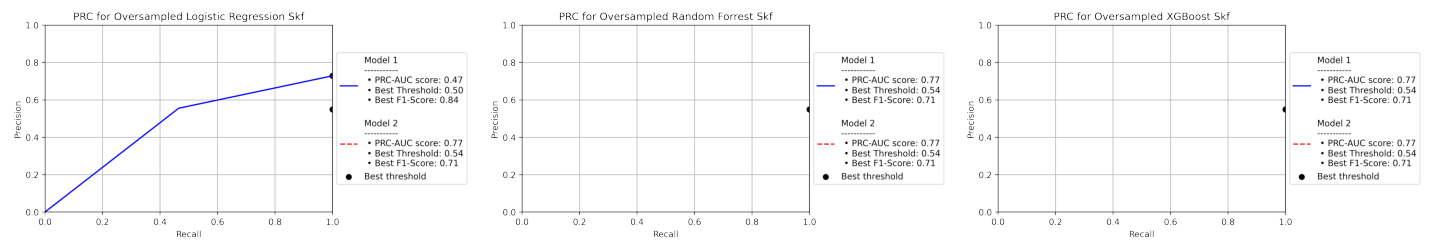

In [90]:
img_A = mpimg.imread('../../img/Geronimo/graphs/Precision vs. Recall Results/Figure_0.png')
img_B = mpimg.imread('../../img/Geronimo/graphs/Precision vs. Recall Results/Figure_1.png')
img_C = mpimg.imread('../../img/Geronimo/graphs/Precision vs. Recall Results/Figure_2.png')
# display images
fig, ax = plt.subplots(1,3,figsize=(20,20))
ax[0].imshow(img_A);
ax[0].axis('off')
ax[1].imshow(img_B);
ax[1].axis('off')
ax[2].imshow(img_C);
ax[2].axis('off')
fig.tight_layout()
fig.savefig(f"../../img/Geronimo/graphs/Precision vs. Recall Results/Figure_final.png", dpi=300, bbox_inches='tight')